# Final project: Computation and the Brain
## Pierre Andurand (pa2570), Stoyan Atanassov (sa3457), Nicolae Lari (nl2605), Rodolfo Raimundo (rcr2142)
### Part III - Analysis of performance of ANNs with weight pruning
We will test the following ANNs:

1) FeedForward Autoencoder on Fashion MNIST dataset (image reconstruction task)

2) Convolutional Autoencoder on Fashion MNIST dataset (image reconstruction task)

3) CNN on CIFAR10 (classification - 10 classes)

4) Resnet on CIFAR10

## Imports

In [ ]:
import tensorflow as tf
import keras
from keras import callbacks
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, Activation, Dropout, Flatten, BatchNormalization, AveragePooling2D
from tensorflow.keras.models import Sequential
from keras.datasets import fashion_mnist, cifar10
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
import os




early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
import tensorflow_model_optimization as tfmot

import matplotlib.pyplot as plt
import tempfile
# limit GPU memory to stop kernel crash
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)
#
layers = tf.keras.layers
import numpy as np
print(tf.__version__)
print (gpu_devices)


2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Models

In [ ]:
#Feedforward autoencoder for image compression/reconstruction

def Fautoencoder():
    autoencoder = Sequential()
    autoencoder.add(Dense(2000, activation='relu', input_shape=(784,)))
    autoencoder.add(Dense(500, activation='relu'))
    autoencoder.add(Dense(500, activation='relu'))
    autoencoder.add(Dense(10, activation='sigmoid'))
    autoencoder.add(Dense(500, activation='relu'))
    autoencoder.add(Dense(500, activation='relu'))
    autoencoder.add(Dense(2000, activation='relu'))
    autoencoder.add(Dense(784))

    return autoencoder

def Cautoencoder():
    autoencoder = Sequential()
    autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
    autoencoder.add(MaxPooling2D((2, 2), padding='same'))
    autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    autoencoder.add(MaxPooling2D((2, 2), padding='same'))
    autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    autoencoder.add(MaxPooling2D((2, 2), padding='same'))
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    autoencoder.add(UpSampling2D((2, 2)))
    autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    autoencoder.add(UpSampling2D((2, 2)))
    autoencoder.add(Conv2D(16, (3, 3), activation='relu'))
    autoencoder.add(UpSampling2D((2, 2)))
    autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

    return autoencoder


def CNN(input_shape, num_classes=10):

    #CNN model for CIFAR10

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model





def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x





def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model




def choose_resnet_model(input_shape, n=3, version=1):

    # Model version
    # Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)

    # Computed depth from supplied model parameter n
    if version == 1:
        depth = n * 6 + 2
    elif version == 2:
        depth = n * 9 + 2

    # Model name, depth and version
    model_type = 'ResNet%dv%d' % (depth, version)


    # Input image dimensions.
    #input_shape = x_train.shape[1:]

    if version == 2:
        model = resnet_v2(input_shape=input_shape, depth=depth)
    else:
        model = resnet_v1(input_shape=input_shape, depth=depth)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr_schedule(0)),
                  metrics=['accuracy'])


    return model , model_type





## Training models

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def train_model(model, x_train, y_train, x_test, y_test, batch_size, num_classes, epochs,
                model_name, model_type):

    # Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_models')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)


    if model_type=='supervised':

        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(learning_rate=lr_schedule(0)),
                      metrics=['accuracy'])

        # Prepare callbacks for model saving and for learning rate adjustment.
        checkpoint = ModelCheckpoint(filepath=filepath,
                                     monitor='val_acc',
                                     verbose=1,
                                     save_best_only=True)

        lr_scheduler = LearningRateScheduler(lr_schedule)

        lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                   cooldown=0,
                                   patience=5,
                                   min_lr=0.5e-6)
        callbacks = [checkpoint, lr_reducer, lr_scheduler]

        history=model.fit(x_train, y_train, batch_size=batch_size,
                                epochs=epochs, verbose=1, workers=4,validation_data=(x_test,y_test), callbacks=callbacks)

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(model_name + ' Cross Entropy Loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()


        # Score trained model.
        scores = model.evaluate(x_test, y_test, verbose=1)
        #print('Supervised learning model with '+str(epochs)+'epochs \n')
        #print('Test loss:', scores[0])
        #print('Test accuracy:', scores[1])

        y_pred = model.predict(x_test)

        cce = tf.keras.losses.CategoricalCrossentropy()

        cc_error=cce(y_test, y_pred).numpy()

        weights = model.get_weights()  #to make sure we use the same pre pruning weights

        # Save model and weights
        model.save(filepath)
        print('Saved trained model at %s ' % filepath)

        return weights, y_pred, cc_error, filepath

    elif model_type=='unsupervised':  #for autoencoders

        #Compiling with loss function being mean squared error
        model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse')
        #Training model with 500 epochs, with early stopper if no improvement for 10 epochs
        #output is compared with input image
        history = model.fit(x_train, x_train, epochs=epochs, batch_size=1288, validation_data=(x_test, x_test), callbacks=[early_stopper])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(model_name + ' MSE Loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

        #saving weights
        weights=model.get_weights()
        model.save(filepath)
        # to predict the reconstructed images for the original images...
        pred = model.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        mse_error=mse(x_test, pred).numpy()

        return weights, pred, mse_error, filepath




## Pruning functions

In [ ]:
#####NOTE#####
# There is a bug in tfmot.sparsity.keras.PolynomialDecay#
# When I try to pass final_sparsity=final_sparsity it triggers an error
# When we input a number manually it works
#########


def pruning01(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    # Function pruning 1% of weights of model over epochs epochs and returning the error on test data

    model.set_weights(init) #to make sure we start with initial weights of after pre pruning training

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = x_train.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=0.01,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)

    if model_type=='supervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy')
        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
                    ]
        # Fitting data
        model_pruning.fit(x_train, y_train,
                          batch_size=batch_size,
                          validation_data=(x_test,y_test),
                          epochs=epochs,
                          callbacks=callbacks)

        # predict and error calculation
        pred_pruning = model_pruning.predict(x_test)
        cce = tf.keras.losses.CategoricalCrossentropy()
        error_prun=cce(y_test, pred_pruning).numpy()

        return error_prun, model_pruning

    elif model_type=='unsupervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse') #MSE

        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
        ]

        # Fitting data
        model_pruning.fit(x_train, x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks)

        # to predict the reconstructed images for the original images...
        pred_pruning = model_pruning.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        error_prun=mse(x_test, pred_pruning).numpy()

        return error_prun, model_pruning

def pruning02(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    # Function pruning 2% of weights of model over epochs epochs and returning the error on test data

    model.set_weights(init) #to make sure we start with initial weights of after pre pruning training

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = x_train.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=0.02,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)

    if model_type=='supervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy')
        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
                    ]
        # Fitting data
        model_pruning.fit(x_train, y_train,
                          batch_size=batch_size,
                          validation_data=(x_test,y_test),
                          epochs=epochs,
                          callbacks=callbacks)

        # predict and error calculation
        pred_pruning = model_pruning.predict(x_test)
        cce = tf.keras.losses.CategoricalCrossentropy()
        error_prun=cce(y_test, pred_pruning).numpy()

        return error_prun, model_pruning

    elif model_type=='unsupervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse') #MSE

        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
        ]

        # Fitting data
        model_pruning.fit(x_train, x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks)

        # to predict the reconstructed images for the original images...
        pred_pruning = model_pruning.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        error_prun=mse(x_test, pred_pruning).numpy()

        return error_prun, model_pruning


def pruning03(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    # Function pruning 3% of weights of model over epochs epochs and returning the error on test data

    model.set_weights(init) #to make sure we start with initial weights of after pre pruning training

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = x_train.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=0.03,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)

    if model_type=='supervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy')
        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
                    ]
        # Fitting data
        model_pruning.fit(x_train, y_train,
                          batch_size=batch_size,
                          validation_data=(x_test,y_test),
                          epochs=epochs,
                          callbacks=callbacks)

        # predict and error calculation
        pred_pruning = model_pruning.predict(x_test)
        cce = tf.keras.losses.CategoricalCrossentropy()
        error_prun=cce(y_test, pred_pruning).numpy()

        return error_prun, model_pruning

    elif model_type=='unsupervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse') #MSE

        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
        ]

        # Fitting data
        model_pruning.fit(x_train, x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks)

        # to predict the reconstructed images for the original images...
        pred_pruning = model_pruning.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        error_prun=mse(x_test, pred_pruning).numpy()

        return error_prun, model_pruning



def pruning04(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    # Function pruning 1% of weights of model over epochs epochs and returning the error on test data

    model.set_weights(init) #to make sure we start with initial weights of after pre pruning training

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = x_train.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=0.04,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)

    if model_type=='supervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy')
        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
                    ]
        # Fitting data
        model_pruning.fit(x_train, y_train,
                          batch_size=batch_size,
                          validation_data=(x_test,y_test),
                          epochs=epochs,
                          callbacks=callbacks)

        # predict and error calculation
        pred_pruning = model_pruning.predict(x_test)
        cce = tf.keras.losses.CategoricalCrossentropy()
        error_prun=cce(y_test, pred_pruning).numpy()

        return error_prun, model_pruning

    elif model_type=='unsupervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse') #MSE

        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
        ]

        # Fitting data
        model_pruning.fit(x_train, x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks)

        # to predict the reconstructed images for the original images...
        pred_pruning = model_pruning.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        error_prun=mse(x_test, pred_pruning).numpy()

        return error_prun, model_pruning


def pruning05(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    # Function pruning 5% of weights of model over epochs epochs and returning the error on test data

    model.set_weights(init) #to make sure we start with initial weights of after pre pruning training

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = x_train.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=0.05,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)

    if model_type=='supervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy')
        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
                    ]
        # Fitting data
        model_pruning.fit(x_train, y_train,
                          batch_size=batch_size,
                          validation_data=(x_test,y_test),
                          epochs=epochs,
                          callbacks=callbacks)

        # predict and error calculation
        pred_pruning = model_pruning.predict(x_test)
        cce = tf.keras.losses.CategoricalCrossentropy()
        error_prun=cce(y_test, pred_pruning).numpy()

        return error_prun, model_pruning

    elif model_type=='unsupervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse') #MSE

        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
        ]

        # Fitting data
        model_pruning.fit(x_train, x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks)

        # to predict the reconstructed images for the original images...
        pred_pruning = model_pruning.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        error_prun=mse(x_test, pred_pruning).numpy()

        return error_prun, model_pruning

def pruning10(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    # Function pruning 10% of weights of model over epochs epochs and returning the error on test data

    model.set_weights(init) #to make sure we start with initial weights of after pre pruning training

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = x_train.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=0.10,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)

    if model_type=='supervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy')
        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
                    ]
        # Fitting data
        model_pruning.fit(x_train, y_train,
                          batch_size=batch_size,
                          validation_data=(x_test,y_test),
                          epochs=epochs,
                          callbacks=callbacks)

        # predict and error calculation
        pred_pruning = model_pruning.predict(x_test)
        cce = tf.keras.losses.CategoricalCrossentropy()
        error_prun=cce(y_test, pred_pruning).numpy()

        return error_prun, model_pruning

    elif model_type=='unsupervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse') #MSE

        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
        ]

        # Fitting data
        model_pruning.fit(x_train, x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks)

        # to predict the reconstructed images for the original images...
        pred_pruning = model_pruning.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        error_prun=mse(x_test, pred_pruning).numpy()

        return error_prun, model_pruning

def pruning15(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    # Function pruning 15% of weights of model over epochs epochs and returning the error on test data

    model.set_weights(init) #to make sure we start with initial weights of after pre pruning training

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = x_train.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=0.15,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)

    if model_type=='supervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy')
        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
                    ]
        # Fitting data
        model_pruning.fit(x_train, y_train,
                          batch_size=batch_size,
                          validation_data=(x_test,y_test),
                          epochs=epochs,
                          callbacks=callbacks)

        # predict and error calculation
        pred_pruning = model_pruning.predict(x_test)
        cce = tf.keras.losses.CategoricalCrossentropy()
        error_prun=cce(y_test, pred_pruning).numpy()

        return error_prun, model_pruning

    elif model_type=='unsupervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse') #MSE

        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
        ]

        # Fitting data
        model_pruning.fit(x_train, x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks)

        # to predict the reconstructed images for the original images...
        pred_pruning = model_pruning.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        error_prun=mse(x_test, pred_pruning).numpy()

        return error_prun, model_pruning


def pruning20(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    # Function pruning 20% of weights of model over epochs epochs and returning the error on test data

    model.set_weights(init) #to make sure we start with initial weights of after pre pruning training

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = x_train.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=0.2,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)

    if model_type=='supervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy')
        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
                    ]
        # Fitting data
        model_pruning.fit(x_train, y_train,
                          batch_size=batch_size,
                          validation_data=(x_test,y_test),
                          epochs=epochs,
                          callbacks=callbacks)

        # predict and error calculation
        pred_pruning = model_pruning.predict(x_test)
        cce = tf.keras.losses.CategoricalCrossentropy()
        error_prun=cce(y_test, pred_pruning).numpy()

        return error_prun, model_pruning

    elif model_type=='unsupervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse') #MSE

        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
        ]

        # Fitting data
        model_pruning.fit(x_train, x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks)

        # to predict the reconstructed images for the original images...
        pred_pruning = model_pruning.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        error_prun=mse(x_test, pred_pruning).numpy()

        return error_prun, model_pruning

def pruning25(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    # Function pruning 25% of weights of model over epochs epochs and returning the error on test data

    model.set_weights(init) #to make sure we start with initial weights of after pre pruning training

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = x_train.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=0.25,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)

    if model_type=='supervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy')
        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
                    ]
        # Fitting data
        model_pruning.fit(x_train, y_train,
                          batch_size=batch_size,
                          validation_data=(x_test,y_test),
                          epochs=epochs,
                          callbacks=callbacks)

        # predict and error calculation
        pred_pruning = model_pruning.predict(x_test)
        cce = tf.keras.losses.CategoricalCrossentropy()
        error_prun=cce(y_test, pred_pruning).numpy()

        return error_prun, model_pruning

    elif model_type=='unsupervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse') #MSE

        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
        ]

        # Fitting data
        model_pruning.fit(x_train, x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks)

        # to predict the reconstructed images for the original images...
        pred_pruning = model_pruning.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        error_prun=mse(x_test, pred_pruning).numpy()

        return error_prun, model_pruning


def pruning30(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    # Function pruning 30% of weights of model over epochs epochs and returning the error on test data

    model.set_weights(init) #to make sure we start with initial weights of after pre pruning training

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = x_train.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=0.3,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)

    if model_type=='supervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy')
        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
                    ]
        # Fitting data
        model_pruning.fit(x_train, y_train,
                          batch_size=batch_size,
                          validation_data=(x_test,y_test),
                          epochs=epochs,
                          callbacks=callbacks)

        # predict and error calculation
        pred_pruning = model_pruning.predict(x_test)
        cce = tf.keras.losses.CategoricalCrossentropy()
        error_prun=cce(y_test, pred_pruning).numpy()

        return error_prun, model_pruning

    elif model_type=='unsupervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse') #MSE

        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
        ]

        # Fitting data
        model_pruning.fit(x_train, x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks)

        # to predict the reconstructed images for the original images...
        pred_pruning = model_pruning.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        error_prun=mse(x_test, pred_pruning).numpy()

        return error_prun, model_pruning

def pruning40(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    # Function pruning 40% of weights of model over epochs epochs and returning the error on test data

    model.set_weights(init) #to make sure we start with initial weights of after pre pruning training

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = x_train.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=0.4,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)

    if model_type=='supervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy')
        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
                    ]
        # Fitting data
        model_pruning.fit(x_train, y_train,
                          batch_size=batch_size,
                          validation_data=(x_test,y_test),
                          epochs=epochs,
                          callbacks=callbacks)

        # predict and error calculation
        pred_pruning = model_pruning.predict(x_test)
        cce = tf.keras.losses.CategoricalCrossentropy()
        error_prun=cce(y_test, pred_pruning).numpy()

        return error_prun, model_pruning

    elif model_type=='unsupervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse') #MSE

        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
        ]

        # Fitting data
        model_pruning.fit(x_train, x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks)

        # to predict the reconstructed images for the original images...
        pred_pruning = model_pruning.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        error_prun=mse(x_test, pred_pruning).numpy()

        return error_prun, model_pruning

def pruning50(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    # Function pruning 50% of weights of model over epochs epochs and returning the error on test data

    model.set_weights(init) #to make sure we start with initial weights of after pre pruning training

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = x_train.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=0.5,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)

    if model_type=='supervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy')
        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
                    ]
        # Fitting data
        model_pruning.fit(x_train, y_train,
                          batch_size=batch_size,
                          validation_data=(x_test,y_test),
                          epochs=epochs,
                          callbacks=callbacks)

        # predict and error calculation
        pred_pruning = model_pruning.predict(x_test)
        cce = tf.keras.losses.CategoricalCrossentropy()
        error_prun=cce(y_test, pred_pruning).numpy()

        return error_prun, model_pruning

    elif model_type=='unsupervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse') #MSE

        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
        ]

        # Fitting data
        model_pruning.fit(x_train, x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks)

        # to predict the reconstructed images for the original images...
        pred_pruning = model_pruning.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        error_prun=mse(x_test, pred_pruning).numpy()

        return error_prun, model_pruning


def pruning60(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    # Function pruning 60% of weights of model over epochs epochs and returning the error on test data

    model.set_weights(init) #to make sure we start with initial weights of after pre pruning training

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = x_train.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=0.6,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)

    if model_type=='supervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy')
        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
                    ]
        # Fitting data
        model_pruning.fit(x_train, y_train,
                          batch_size=batch_size,
                          validation_data=(x_test,y_test),
                          epochs=epochs,
                          callbacks=callbacks)

        # predict and error calculation
        pred_pruning = model_pruning.predict(x_test)
        cce = tf.keras.losses.CategoricalCrossentropy()
        error_prun=cce(y_test, pred_pruning).numpy()

        return error_prun, model_pruning

    elif model_type=='unsupervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse') #MSE

        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
        ]

        # Fitting data
        model_pruning.fit(x_train, x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks)

        # to predict the reconstructed images for the original images...
        pred_pruning = model_pruning.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        error_prun=mse(x_test, pred_pruning).numpy()

        return error_prun, model_pruning

def pruning70(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    # Function pruning 70% of weights of model over epochs epochs and returning the error on test data

    model.set_weights(init) #to make sure we start with initial weights of after pre pruning training

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = x_train.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=0.7,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)

    if model_type=='supervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy')
        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
                    ]
        # Fitting data
        model_pruning.fit(x_train, y_train,
                          batch_size=batch_size,
                          validation_data=(x_test,y_test),
                          epochs=epochs,
                          callbacks=callbacks)

        # predict and error calculation
        pred_pruning = model_pruning.predict(x_test)
        cce = tf.keras.losses.CategoricalCrossentropy()
        error_prun=cce(y_test, pred_pruning).numpy()

        return error_prun, model_pruning

    elif model_type=='unsupervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse') #MSE

        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
        ]

        # Fitting data
        model_pruning.fit(x_train, x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks)

        # to predict the reconstructed images for the original images...
        pred_pruning = model_pruning.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        error_prun=mse(x_test, pred_pruning).numpy()

        return error_prun, model_pruning


def pruning80(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    # Function pruning 80% of weights of model over epochs epochs and returning the error on test data

    model.set_weights(init) #to make sure we start with initial weights of after pre pruning training

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = x_train.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=0.8,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)

    if model_type=='supervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy')
        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
                    ]
        # Fitting data
        model_pruning.fit(x_train, y_train,
                          batch_size=batch_size,
                          validation_data=(x_test,y_test),
                          epochs=epochs,
                          callbacks=callbacks)

        # predict and error calculation
        pred_pruning = model_pruning.predict(x_test)
        cce = tf.keras.losses.CategoricalCrossentropy()
        error_prun=cce(y_test, pred_pruning).numpy()

        return error_prun, model_pruning

    elif model_type=='unsupervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse') #MSE

        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
        ]

        # Fitting data
        model_pruning.fit(x_train, x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks)

        # to predict the reconstructed images for the original images...
        pred_pruning = model_pruning.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        error_prun=mse(x_test, pred_pruning).numpy()

        return error_prun, model_pruning

def pruning90(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    # Function pruning 90% of weights of model over epochs epochs and returning the error on test data

    model.set_weights(init) #to make sure we start with initial weights of after pre pruning training

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    # Compute end step to finish pruning after epochs epochs.

    num_images = x_train.shape[0]
    end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.,
                                                               final_sparsity=0.9,
                                                               begin_step=0,
                                                               end_step=end_step)
    }

    model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)

    if model_type=='supervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='categorical_crossentropy')
        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
                    ]
        # Fitting data
        model_pruning.fit(x_train, y_train,
                          batch_size=batch_size,
                          validation_data=(x_test,y_test),
                          epochs=epochs,
                          callbacks=callbacks)

        # predict and error calculation
        pred_pruning = model_pruning.predict(x_test)
        cce = tf.keras.losses.CategoricalCrossentropy()
        error_prun=cce(y_test, pred_pruning).numpy()

        return error_prun, model_pruning

    elif model_type=='unsupervised':

        model_pruning = prune_low_magnitude(to_prune=model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_pruning.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss='mse') #MSE

        # Model callbacks
        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep()
        ]

        # Fitting data
        model_pruning.fit(x_train, x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=callbacks)

        # to predict the reconstructed images for the original images...
        pred_pruning = model_pruning.predict(x_test)
        mse = tf.keras.losses.MeanSquaredError()
        error_prun=mse(x_test, pred_pruning).numpy()

        return error_prun, model_pruning


def prune_all(model, model_type, init, x_train, y_train, x_test, y_test, batch_size, epochs):

    #####NOTE#####
    # There is a bug in tfmot.sparsity.keras.PolynomialDecay#
    # When I try to pass final_sparsity=final_sparsity it triggers an error
    # When we input a number manually it works
    # Otherwise clearly I would have done a loop
    #########

    # Pruning between 1% and 90% of weights in order to make plot

    err_prun_list=[]

    error_prun, _ = pruning01(model=model, model_type=model_type, init=init, x_train=x_train, y_train=y_train,
                                                 x_test=x_test, y_test=y_test, batch_size=batch_size,epochs=epochs)
    err_prun_list.append(error_prun)

    error_prun, _ = pruning02(model=model, model_type=model_type, init=init, x_train=x_train, y_train=y_train,
                                                 x_test=x_test, y_test=y_test, batch_size=batch_size,epochs=epochs)
    err_prun_list.append(error_prun)

    error_prun, _= pruning03(model=model, model_type=model_type, init=init, x_train=x_train, y_train=y_train,
                                                 x_test=x_test, y_test=y_test, batch_size=batch_size,epochs=epochs)
    err_prun_list.append(error_prun)

    error_prun, _= pruning04(model=model, model_type=model_type, init=init, x_train=x_train, y_train=y_train,
                                                 x_test=x_test, y_test=y_test, batch_size=batch_size,epochs=epochs)
    err_prun_list.append(error_prun)

    error_prun, _= pruning05(model=model, model_type=model_type, init=init, x_train=x_train, y_train=y_train,
                                                 x_test=x_test, y_test=y_test, batch_size=batch_size,epochs=epochs)
    err_prun_list.append(error_prun)

    error_prun, _ = pruning10(model=model, model_type=model_type, init=init, x_train=x_train, y_train=y_train,
                                                 x_test=x_test, y_test=y_test, batch_size=batch_size,epochs=epochs)
    err_prun_list.append(error_prun)

    error_prun, _ = pruning15(model=model, model_type=model_type, init=init, x_train=x_train, y_train=y_train,
                                                 x_test=x_test, y_test=y_test, batch_size=batch_size,epochs=epochs)
    err_prun_list.append(error_prun)

    error_prun, _ = pruning20(model=model, model_type=model_type, init=init, x_train=x_train, y_train=y_train,
                                                 x_test=x_test, y_test=y_test, batch_size=batch_size,epochs=epochs)
    err_prun_list.append(error_prun)

    error_prun, _ = pruning25(model=model, model_type=model_type, init=init, x_train=x_train, y_train=y_train,
                                                 x_test=x_test, y_test=y_test, batch_size=batch_size,epochs=epochs)
    err_prun_list.append(error_prun)

    error_prun, _ = pruning30(model=model, model_type=model_type, init=init, x_train=x_train, y_train=y_train,
                                                 x_test=x_test, y_test=y_test, batch_size=batch_size,epochs=epochs)
    err_prun_list.append(error_prun)

    error_prun, _ = pruning40(model=model, model_type=model_type, init=init, x_train=x_train, y_train=y_train,
                                                 x_test=x_test, y_test=y_test, batch_size=batch_size,epochs=epochs)
    err_prun_list.append(error_prun)

    error_prun, _ = pruning50(model=model, model_type=model_type, init=init, x_train=x_train, y_train=y_train,
                                                 x_test=x_test, y_test=y_test, batch_size=batch_size,epochs=epochs)
    err_prun_list.append(error_prun)

    error_prun, _= pruning60(model=model, model_type=model_type, init=init, x_train=x_train, y_train=y_train,
                                                 x_test=x_test, y_test=y_test, batch_size=batch_size,epochs=epochs)
    err_prun_list.append(error_prun)

    error_prun, _= pruning70(model=model, model_type=model_type, init=init, x_train=x_train, y_train=y_train,
                                                 x_test=x_test, y_test=y_test, batch_size=batch_size,epochs=epochs)
    err_prun_list.append(error_prun)

    error_prun, _= pruning80(model=model, model_type=model_type, init=init, x_train=x_train, y_train=y_train,
                                                 x_test=x_test, y_test=y_test, batch_size=batch_size,epochs=epochs)
    err_prun_list.append(error_prun)

    error_prun, last_model = pruning90(model=model, model_type=model_type, init=init, x_train=x_train, y_train=y_train,
                                                 x_test=x_test, y_test=y_test, batch_size=batch_size,epochs=epochs)
    err_prun_list.append(error_prun)

    return err_prun_list, last_model

### Results functions

In [ ]:
def run_train_and_prune(model_name, model_type, x_train, y_train, x_test, y_test, iterations, epochs, epochs_prun, dataset):
    #Pruning model and getting errors per percentage of synapses pruned
    #With loops so that we check with different initialized weights and have error bars

    err_list=[]
    err_nopruning=[]

    for i in range(iterations):

        if model_name=='Resnet':
            model, _ = choose_resnet_model(input_shape=x_train.shape[1:], n=3, version=1)
        elif model_name=='CNN':
            model = CNN(input_shape=x_train.shape[1:])
        elif model_name=='Fautoencoder':
            model = Fautoencoder()
        elif model_name == 'Cautoencoder':
            model = Cautoencoder()


        weights, pred, error, filepath = train_model(model=model, x_train=x_train, y_train=y_train, x_test=x_test,
                                                     y_test=y_test, batch_size=32,
                                                      num_classes=10, epochs=epochs,
                                                       model_name= model_name, model_type=model_type)
        print("i= ",i)
        if i==0:
            if model_type=='unsupervised':

                #Plotting images and reconstructed images
                n = 10  # How many picture we will display
                plt.figure(figsize=(20, 4))
                for j in range(n):
                    # Display original
                    ax = plt.subplot(2, n, j + 1)
                    plt.imshow(x_test[j].reshape(28, 28))
                    #plt.gray()
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)

                    # Display reconstruction
                    ax = plt.subplot(2, n, j + 1 + n)
                    plt.imshow(pred[j].reshape(28, 28))
                    #plt.gray()
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)
                plt.title('Image reconstruction model: '+ model_name)
                plt.show()


        err_prun_list, last_model = prune_all(model, model_type, weights, x_train, y_train, x_test, y_test,
                                  batch_size=128, epochs=epochs_prun)

        y_pruned = last_model.predict(x_test)

        if i==0:
            if model_type=='unsupervised':

                #Plotting images and reconstructed images
                n = 10  # How many picture we will display
                plt.figure(figsize=(20, 4))
                for j in range(n):
                    # Display original
                    ax = plt.subplot(2, n, j + 1)
                    plt.imshow(x_test[j].reshape(28, 28))
                    #plt.gray()
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)

                    # Display reconstruction
                    ax = plt.subplot(2, n, j + 1 + n)
                    plt.imshow(y_pruned[j].reshape(28, 28))
                    #plt.gray()
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)
                plt.title('90% Pruned Image reconstruction model: '+ model_name)
                plt.show()




        err_list.append(err_prun_list)
        err_nopruning.append(error)



    err_nopruning_mean=np.mean(err_nopruning)
    err_nopruning_max=np.max(err_nopruning)
    err_nopruning_min=np.min(err_nopruning)
    err_nopruning_bar=(err_nopruning_max-err_nopruning_min)/2

    err_list=np.array(err_list)
    error_mean=np.mean(err_list, axis=0)
    error_max=np.amax(err_list, axis=0)
    error_min=np.amin(err_list, axis=0)
    error_bar=(error_max-error_min)/2

    synapse_deletion=[0.01,0.02,0.03,0.04,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    synapse_deletion=np.array(synapse_deletion)
    n=len(synapse_deletion)

    err_nopruning_mean_list=np.ones(n)*err_nopruning_mean
    err_nopruning_bar_list=np.ones(n)*err_nopruning_bar

    plt.errorbar(synapse_deletion, error_mean, yerr=error_bar, label = 'Pruning', color='r')
    plt.errorbar(synapse_deletion, err_nopruning_mean_list, yerr=err_nopruning_bar_list, label = 'No Pruning', color='k')


    if model_type=='supervised':
        plt.title(model_name + " Categorical Cross Entropy Loss as a function of synapse deletion \n trained on " + str(epochs) +
                  " epochs \n pruning over " + str(epochs_prun) + " epochs \n"+ dataset)
        plt.xlabel("Synapse percentage deletion")
        plt.ylabel("Categorical Cross Entropy Loss")
        plt.legend(loc='upper left')
        plt.show()

    elif model_type=='unsupervised':
        plt.title(model_name + " Mean Square Error Loss as a function of synapse deletion \n trained on " + str(epochs) +
                  " epochs \n pruning over " + str(epochs_prun) + " epochs \n"+ dataset)
        plt.xlabel("Synapse percentage deletion")
        plt.ylabel("MSE Loss")
        plt.legend(loc='upper left')
        plt.show()

    return synapse_deletion, error_mean, error_bar, err_nopruning_mean_list, err_nopruning_bar_list

## Test and results

### Fashion MNIST dataset

In [ ]:
# Loading Fashion MNIST datset

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# converting all the pixel values from range(0 to 255) to range(0,1)
x_train= x_train/255.
x_test = x_test/255.

### FeedForward Autoencoder

Dimension of training data before reshaping (60000, 28, 28)
Dimension of training data after reshaping (60000, 784)
Dimension of validation data after reshaping (10000, 784)
Epoch 1/200
47/47 [==============================] - 1s 19ms/step - loss: 0.0806 - val_loss: 0.0569
Epoch 2/200
47/47 [==============================] - 1s 13ms/step - loss: 0.0470 - val_loss: 0.0389
Epoch 3/200
47/47 [==============================] - 1s 13ms/step - loss: 0.0369 - val_loss: 0.0363
Epoch 4/200
47/47 [==============================] - 1s 13ms/step - loss: 0.0319 - val_loss: 0.0287
Epoch 5/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0267 - val_loss: 0.0250
Epoch 6/200
47/47 [==============================] - 1s 13ms/step - loss: 0.0243 - val_loss: 0.0235
Epoch 7/200
47/47 [==============================] - 1s 13ms/step - loss: 0.0226 - val_loss: 0.0219
Epoch 8/200
47/47 [==============================] - 1s 13ms/step - loss: 0.0215 - val_loss: 0.0212
Epoch 9/200
47/47 [=======

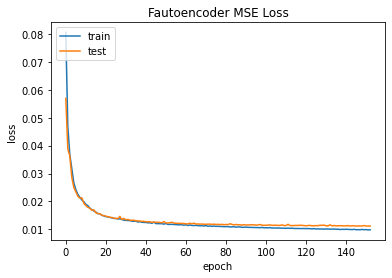

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  0


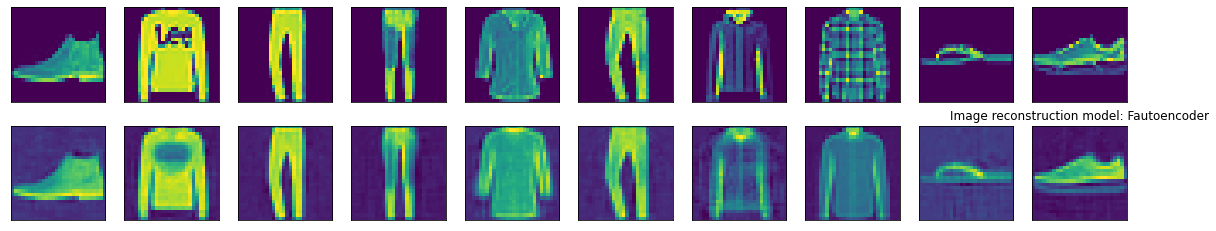

Instructions for updating:
Please use `layer.add_weight` method instead.
469/469 [==============================] - 4s 8ms/step - loss: 0.0201


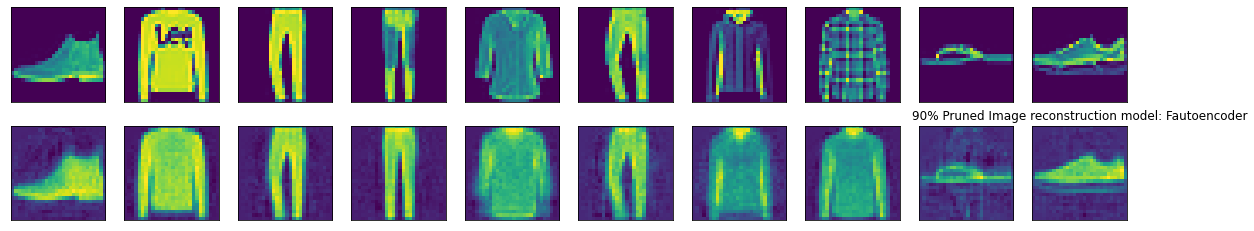

Epoch 1/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0795 - val_loss: 0.0563
Epoch 2/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0456 - val_loss: 0.0385
Epoch 3/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0363 - val_loss: 0.0329
Epoch 4/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0306 - val_loss: 0.0313
Epoch 5/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0266 - val_loss: 0.0250
Epoch 6/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0242 - val_loss: 0.0235
Epoch 7/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0226 - val_loss: 0.0218
Epoch 8/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0212 - val_loss: 0.0204
Epoch 9/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0203 - val_loss: 0.0193
Epoch 10/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0189 - val_loss: 0.0184
Epo

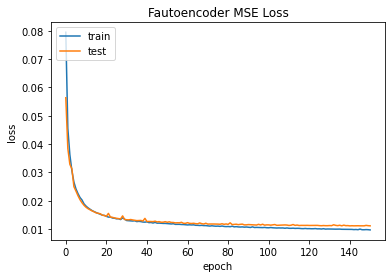

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  1
469/469 [==============================] - 4s 8ms/step - loss: 0.0190
Epoch 1/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0806 - val_loss: 0.0530
Epoch 2/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0448 - val_loss: 0.0382
Epoch 3/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0353 - val_loss: 0.0316
Epoch 4/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0300 - val_loss: 0.0271
Epoch 5/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0257 - val_loss: 0.0246
Epoch 6/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0239 - val_loss: 0.0230
Epoch 7/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0222 - val_loss: 0.0214
Epoch 8/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0208 - val_loss: 0.0206
Epoch 9/200
47/47 [

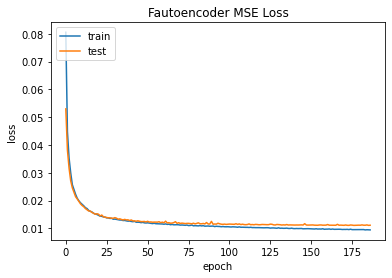

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  2
469/469 [==============================] - 4s 8ms/step - loss: 0.0207
Epoch 1/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0812 - val_loss: 0.0572
Epoch 2/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0460 - val_loss: 0.0386
Epoch 3/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0364 - val_loss: 0.0339
Epoch 4/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0310 - val_loss: 0.0286
Epoch 5/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0268 - val_loss: 0.0250
Epoch 6/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0246 - val_loss: 0.0236
Epoch 7/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0229 - val_loss: 0.0221
Epoch 8/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0216 - val_loss: 0.0209
Epoch 9/200
47/47 [=

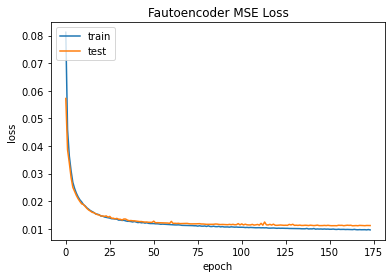

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  3
469/469 [==============================] - 4s 8ms/step - loss: 0.0194
Epoch 1/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0805 - val_loss: 0.0557
Epoch 2/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0457 - val_loss: 0.0389
Epoch 3/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0358 - val_loss: 0.0323
Epoch 4/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0300 - val_loss: 0.0275
Epoch 5/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0259 - val_loss: 0.0246
Epoch 6/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0238 - val_loss: 0.0232
Epoch 7/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0226 - val_loss: 0.0224
Epoch 8/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0213 - val_loss: 0.0209
Epoch 9/200
47/47 [===

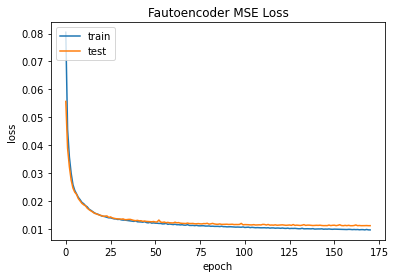

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  4
469/469 [==============================] - 4s 8ms/step - loss: 0.0197


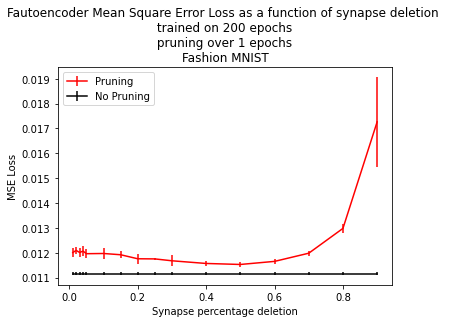

In [ ]:
#converting the Image data into values of pixels, i.e. - image of dimension 28 X 28 to single row of 784 pixels(28x28 = 784).
print("Dimension of training data before reshaping",x_train.shape)
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
print("Dimension of training data after reshaping",x_train.shape)
print("Dimension of validation data after reshaping",x_test.shape)


synapse_deletion1, error_mean1, error_bar1, err_nopruning_mean1, err_nopruning_bar1 = run_train_and_prune('Fautoencoder', 'unsupervised', x_train, y_train, x_test, y_test, iterations=5, epochs=200, epochs_prun=1, dataset='Fashion MNIST')

Dimension of training data before reshaping (60000, 784)
Dimension of training data after reshaping (60000, 784)
Dimension of validation data after reshaping (10000, 784)
Epoch 1/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0824 - val_loss: 0.0585
Epoch 2/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0459 - val_loss: 0.0376
Epoch 3/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0347 - val_loss: 0.0310
Epoch 4/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0293 - val_loss: 0.0276
Epoch 5/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0255 - val_loss: 0.0242
Epoch 6/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0232 - val_loss: 0.0224
Epoch 7/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0220 - val_loss: 0.0227
Epoch 8/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0207 - val_loss: 0.0223
Epoch 9/200
47/47 [=================

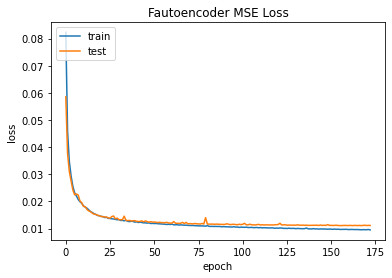

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  0


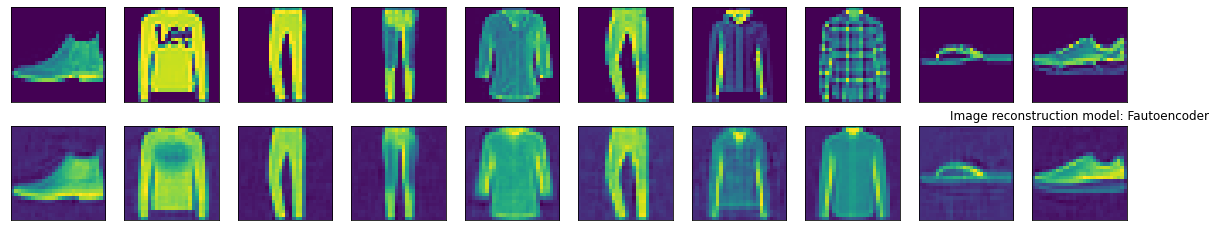

Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0113
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0110
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0109
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0109
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0113
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0110
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0109
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0113
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0110
Epoch 3/5
469/469 [=====================

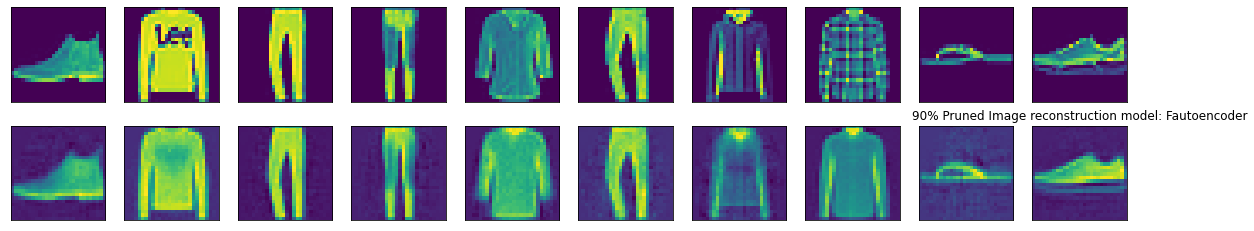

Epoch 1/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0838 - val_loss: 0.0585
Epoch 2/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0483 - val_loss: 0.0403
Epoch 3/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0367 - val_loss: 0.0320
Epoch 4/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0293 - val_loss: 0.0268
Epoch 5/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0250 - val_loss: 0.0238
Epoch 6/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0237 - val_loss: 0.0224
Epoch 7/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0215 - val_loss: 0.0209
Epoch 8/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0205 - val_loss: 0.0207
Epoch 9/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0195 - val_loss: 0.0191
Epoch 10/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 

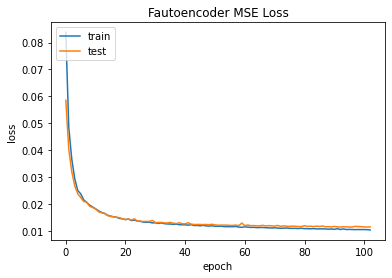

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  1
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0121
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0115
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0115
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0114
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0113
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0120
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0116
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0115
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0114
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0113
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0120
Epoch

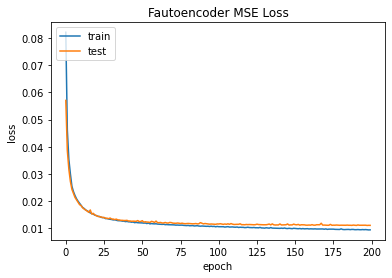

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  2
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0113
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0111
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0109
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0109
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0112
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0110
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0109
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0107
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0112
Epoch

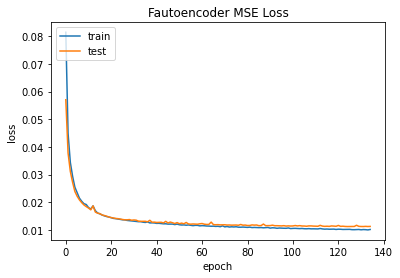

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  3
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0124
Epoch 2/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0113
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0112
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0112
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0111
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0124
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0112
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0112
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0112
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0111
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0124
Epoch

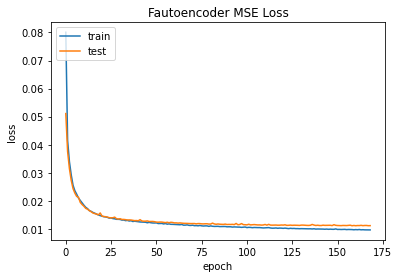

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  4
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0115
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0111
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0111
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0109
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0109
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0114
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0111
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0110
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0110
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0109
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0114
Epoch

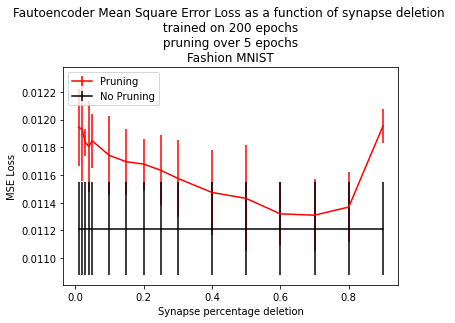

In [ ]:
#converting the Image data into values of pixels, i.e. - image of dimension 28 X 28 to single row of 784 pixels(28x28 = 784).
print("Dimension of training data before reshaping",x_train.shape)
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
print("Dimension of training data after reshaping",x_train.shape)
print("Dimension of validation data after reshaping",x_test.shape)


synapse_deletion1, error_mean1, error_bar1, err_nopruning_mean1, err_nopruning_bar1 = run_train_and_prune('Fautoencoder', 'unsupervised', x_train, y_train, x_test, y_test, iterations=5, epochs=200, epochs_prun=5, dataset='Fashion MNIST')

Dimension of training data before reshaping (60000, 784)
Dimension of training data after reshaping (60000, 784)
Dimension of validation data after reshaping (10000, 784)
Epoch 1/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0816 - val_loss: 0.0574
Epoch 2/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0459 - val_loss: 0.0382
Epoch 3/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0366 - val_loss: 0.0328
Epoch 4/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0303 - val_loss: 0.0280
Epoch 5/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0266 - val_loss: 0.0250
Epoch 6/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0239 - val_loss: 0.0232
Epoch 7/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0225 - val_loss: 0.0224
Epoch 8/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0215 - val_loss: 0.0211
Epoch 9/200
47/47 [=================

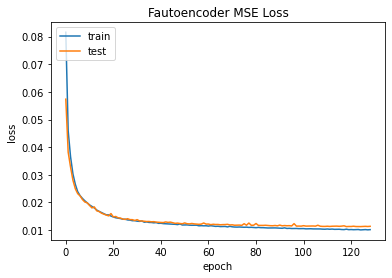

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  0


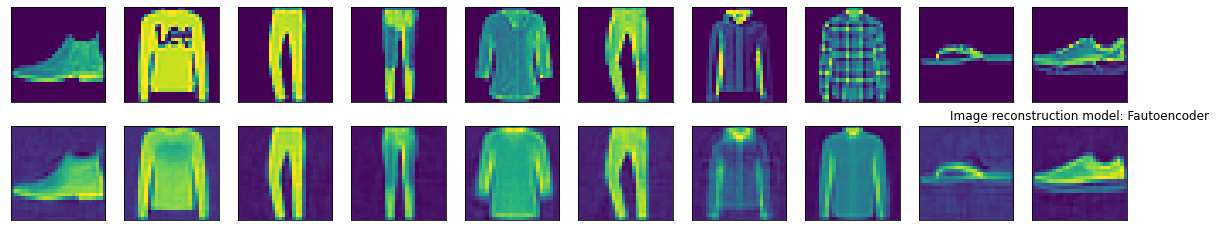

Epoch 1/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0117
Epoch 2/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0114
Epoch 3/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0113
Epoch 4/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0112
Epoch 5/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0112
Epoch 6/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0111
Epoch 7/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0110
Epoch 8/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0110
Epoch 9/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 10/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 11/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 12/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0106
Epoch 13/25
469/469 [====

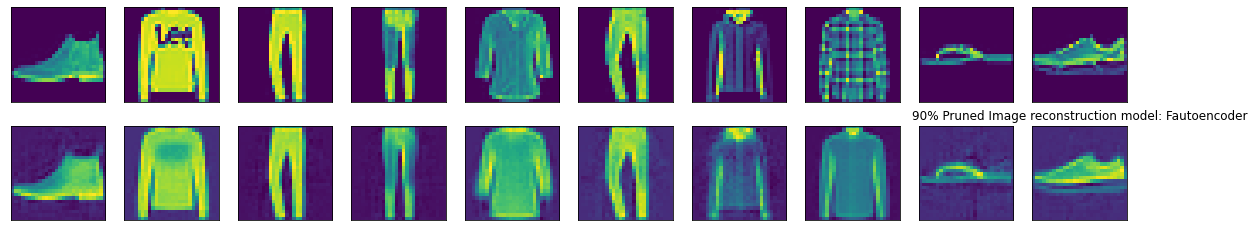

Epoch 1/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0810 - val_loss: 0.0555
Epoch 2/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0461 - val_loss: 0.0384
Epoch 3/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0359 - val_loss: 0.0324
Epoch 4/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0293 - val_loss: 0.0267
Epoch 5/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0253 - val_loss: 0.0242
Epoch 6/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0236 - val_loss: 0.0229
Epoch 7/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0221 - val_loss: 0.0213
Epoch 8/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0207 - val_loss: 0.0240
Epoch 9/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0200 - val_loss: 0.0195
Epoch 10/200
47/47 [==============================] - 0s 9ms/step - loss: 0.0188 - val_loss: 0.0186
Epoch 11

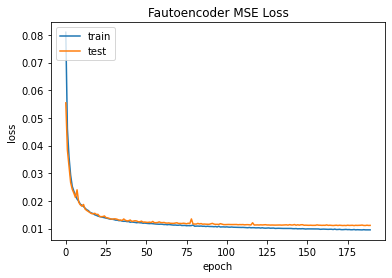

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  1
Epoch 1/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0113
Epoch 2/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0111
Epoch 3/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0110
Epoch 4/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0109
Epoch 5/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 6/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 7/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 8/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 9/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0106
Epoch 10/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0105
Epoch 11/25
469/469 [==============================] - 4s 8ms/step - loss:

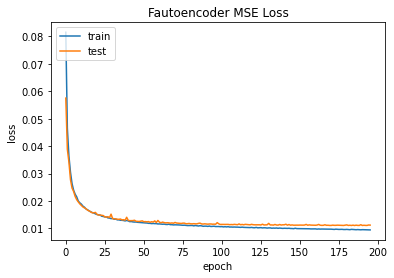

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  2
Epoch 1/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0118
Epoch 2/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0109
Epoch 3/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0109
Epoch 4/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 5/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 6/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0107
Epoch 7/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0107
Epoch 8/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0107
Epoch 9/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0106
Epoch 10/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0105
Epoch 11/25
469/469 [==============================] - 4s 8ms/step - loss:

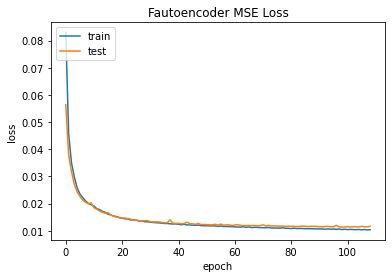

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  3
Epoch 1/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0125
Epoch 2/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0114
Epoch 3/25
469/469 [==============================] - 4s 9ms/step - loss: 0.0114
Epoch 4/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0114
Epoch 5/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0113
Epoch 6/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0112
Epoch 7/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0111
Epoch 8/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0111
Epoch 9/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0110
Epoch 10/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0109
Epoch 11/25
469/469 [==============================] - 4s 8ms/step - loss:

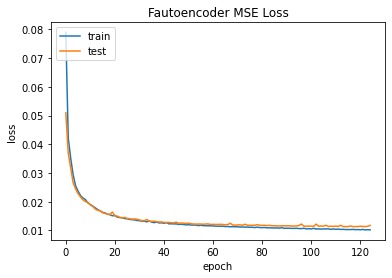

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  4
Epoch 1/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0118
Epoch 2/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0115
Epoch 3/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0113
Epoch 4/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0113
Epoch 5/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0112
Epoch 6/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0111
Epoch 7/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0110
Epoch 8/25
469/469 [==============================] - 4s 9ms/step - loss: 0.0110
Epoch 9/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0109
Epoch 10/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0108
Epoch 11/25
469/469 [==============================] - 4s 9ms/step - loss:

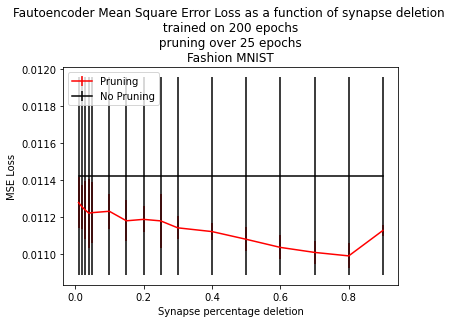

In [ ]:
#converting the Image data into values of pixels, i.e. - image of dimension 28 X 28 to single row of 784 pixels(28x28 = 784).
print("Dimension of training data before reshaping",x_train.shape)
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
print("Dimension of training data after reshaping",x_train.shape)
print("Dimension of validation data after reshaping",x_test.shape)


synapse_deletion1, error_mean1, error_bar1, err_nopruning_mean1, err_nopruning_bar1 = run_train_and_prune('Fautoencoder', 'unsupervised', x_train, y_train, x_test, y_test, iterations=5, epochs=200, epochs_prun=25, dataset='Fashion MNIST')

Dimension of training data before reshaping (60000, 28, 28)
Dimension of training data after reshaping (60000, 784)
Dimension of validation data after reshaping (10000, 784)
Epoch 1/50
47/47 [==============================] - 1s 15ms/step - loss: 0.0801 - val_loss: 0.0562
Epoch 2/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0443 - val_loss: 0.0376
Epoch 3/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0355 - val_loss: 0.0320
Epoch 4/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0293 - val_loss: 0.0268
Epoch 5/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0256 - val_loss: 0.0245
Epoch 6/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0239 - val_loss: 0.0233
Epoch 7/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0232 - val_loss: 0.0223
Epoch 8/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0214 - val_loss: 0.0206
Epoch 9/50
47/47 [================

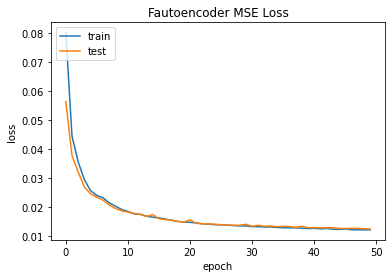

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  0


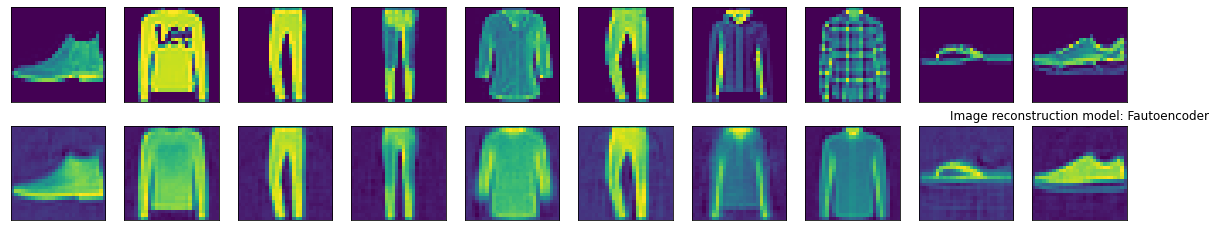

Instructions for updating:
Please use `layer.add_weight` method instead.
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0134
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0128
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0126
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0123
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0121
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0134
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0127
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0125
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0123
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0122
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0134
Epoch 2/5
469/469 [============================

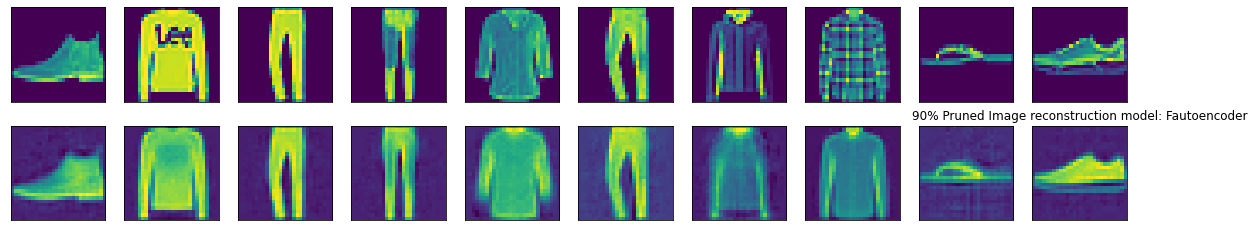

Epoch 1/50
47/47 [==============================] - 1s 11ms/step - loss: 0.0819 - val_loss: 0.0591
Epoch 2/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0468 - val_loss: 0.0384
Epoch 3/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0348 - val_loss: 0.0314
Epoch 4/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0287 - val_loss: 0.0266
Epoch 5/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0251 - val_loss: 0.0242
Epoch 6/50
47/47 [==============================] - 0s 10ms/step - loss: 0.0238 - val_loss: 0.0229
Epoch 7/50
47/47 [==============================] - 0s 9ms/step - loss: 0.0226 - val_loss: 0.0218
Epoch 8/50
47/47 [==============================] - 0s 9ms/step - loss: 0.0214 - val_loss: 0.0216
Epoch 9/50
47/47 [==============================] - 0s 9ms/step - loss: 0.0206 - val_loss: 0.0206
Epoch 10/50
47/47 [==============================] - 0s 9ms/step - loss: 0.0195 - val_loss: 0.0191
Epoch 11/50
4

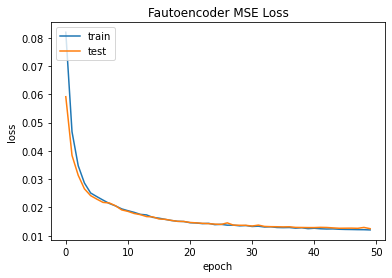

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  1
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0135
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0128
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0126
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0124
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0122
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0136
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0127
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0126
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0123
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0122
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0135
Epoch

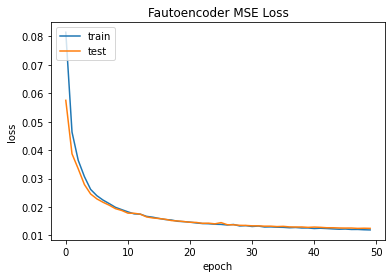

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  2
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0145
Epoch 2/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0126
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0125
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0123
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0121
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0146
Epoch 2/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0125
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0125
Epoch 4/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0123
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0122
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0146
Epoc

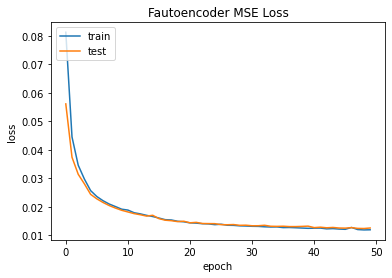

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  3
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0136
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0126
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0125
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0124
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0121
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0137
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0127
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0124
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0123
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0121
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0137
Epoch

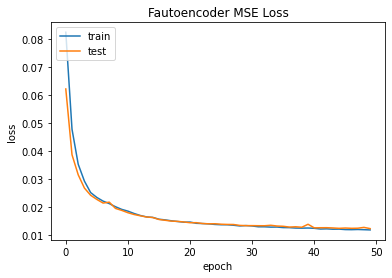

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Fautoencoder/assets
i=  4
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0149
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0124
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0123
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0123
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0120
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0150
Epoch 2/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0124
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0122
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0122
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0120
Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0148
Epoch

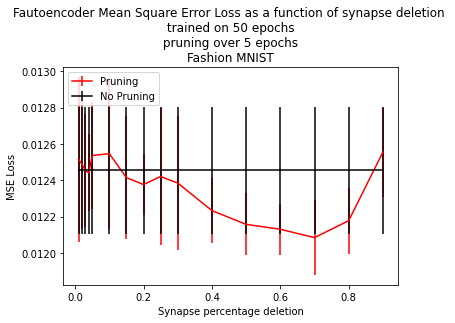

In [ ]:
#converting the Image data into values of pixels, i.e. - image of dimension 28 X 28 to single row of 784 pixels(28x28 = 784).
print("Dimension of training data before reshaping",x_train.shape)
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
print("Dimension of training data after reshaping",x_train.shape)
print("Dimension of validation data after reshaping",x_test.shape)


synapse_deletion1, error_mean1, error_bar1, err_nopruning_mean1, err_nopruning_bar1 = run_train_and_prune('Fautoencoder', 'unsupervised', x_train, y_train, x_test, y_test, iterations=5, epochs=50, epochs_prun=5, dataset='Fashion MNIST')

### Convolutional Autoencoder

Epoch 1/200
47/47 [==============================] - 1s 14ms/step - loss: 0.1420 - val_loss: 0.1035
Epoch 2/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0662 - val_loss: 0.0393
Epoch 3/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0340 - val_loss: 0.0309
Epoch 4/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0291 - val_loss: 0.0277
Epoch 5/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0269 - val_loss: 0.0261
Epoch 6/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0255 - val_loss: 0.0249
Epoch 7/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0245 - val_loss: 0.0241
Epoch 8/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0237 - val_loss: 0.0234
Epoch 9/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0231 - val_loss: 0.0227
Epoch 10/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0225 - val_loss: 0.0222

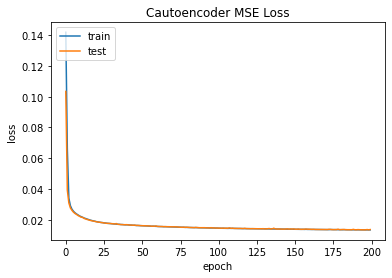

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Cautoencoder/assets
i=  0


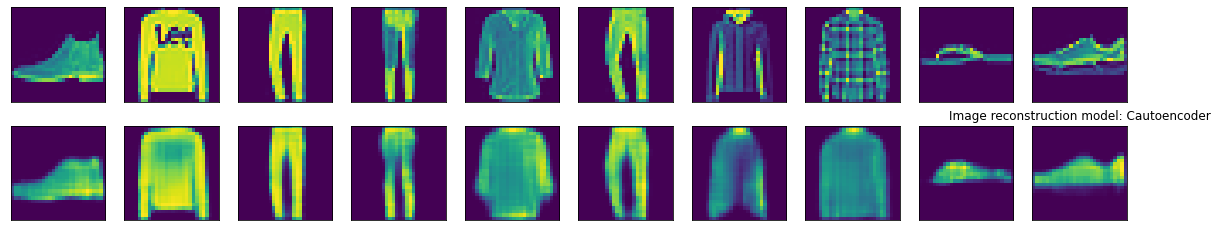

469/469 [==============================] - 5s 10ms/step - loss: 0.0489


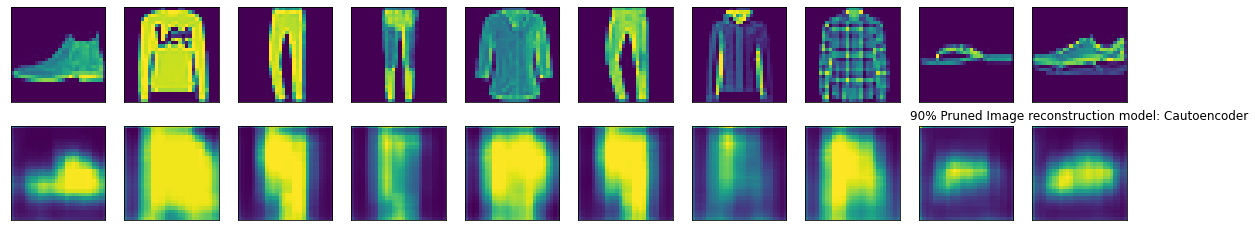

Epoch 1/200
47/47 [==============================] - 1s 14ms/step - loss: 0.1221 - val_loss: 0.0610
Epoch 2/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0440 - val_loss: 0.0363
Epoch 3/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0335 - val_loss: 0.0313
Epoch 4/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0296 - val_loss: 0.0282
Epoch 5/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0271 - val_loss: 0.0261
Epoch 6/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0253 - val_loss: 0.0245
Epoch 7/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0240 - val_loss: 0.0233
Epoch 8/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0230 - val_loss: 0.0225
Epoch 9/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0222 - val_loss: 0.0218
Epoch 10/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0215 - val_loss: 0.0212

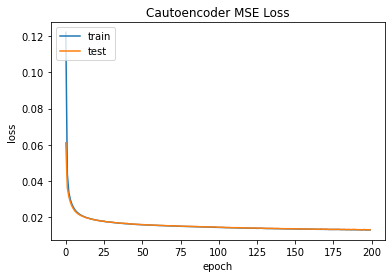

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Cautoencoder/assets
i=  1
469/469 [==============================] - 5s 10ms/step - loss: 0.0361
Epoch 1/200
47/47 [==============================] - 1s 14ms/step - loss: 0.1397 - val_loss: 0.0858
Epoch 2/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0487 - val_loss: 0.0364
Epoch 3/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0340 - val_loss: 0.0317
Epoch 4/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0302 - val_loss: 0.0287
Epoch 5/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0276 - val_loss: 0.0265
Epoch 6/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0260 - val_loss: 0.0253
Epoch 7/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0248 - val_loss: 0.0242
Epoch 8/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0240 - val_loss: 0.0236
Epoch 9/200
47

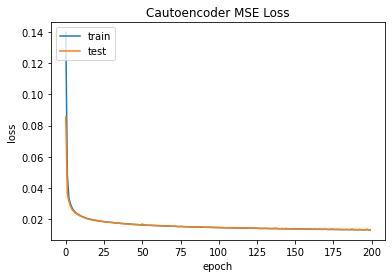

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Cautoencoder/assets
i=  2
469/469 [==============================] - 5s 10ms/step - loss: 0.0478


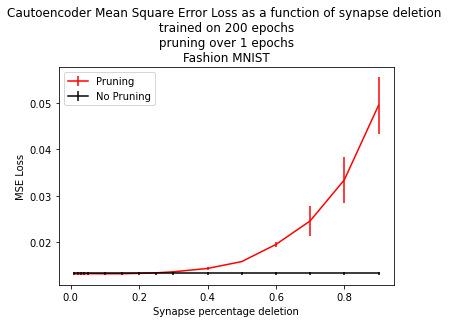

In [ ]:
x_train = x_train.reshape(len(x_train), 28,28,1)
x_test = x_test.reshape(len(x_test), 28,28,1)


synapse_deletion2, error_mean2, error_bar2, err_nopruning_mean2, err_nopruning_bar2 = run_train_and_prune('Cautoencoder', 'unsupervised', x_train, y_train, x_test, y_test, iterations=3, epochs=200, epochs_prun=1, dataset='Fashion MNIST')

Epoch 1/200
47/47 [==============================] - 1s 15ms/step - loss: 0.1247 - val_loss: 0.0752
Epoch 2/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0496 - val_loss: 0.0370
Epoch 3/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0333 - val_loss: 0.0305
Epoch 4/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0293 - val_loss: 0.0278
Epoch 5/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0270 - val_loss: 0.0260
Epoch 6/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0254 - val_loss: 0.0246
Epoch 7/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0241 - val_loss: 0.0236
Epoch 8/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0231 - val_loss: 0.0227
Epoch 9/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0224 - val_loss: 0.0221
Epoch 10/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0219 - val_loss: 0.0216

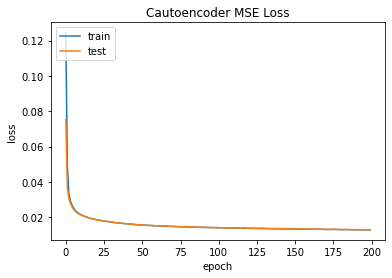

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Cautoencoder/assets
i=  0


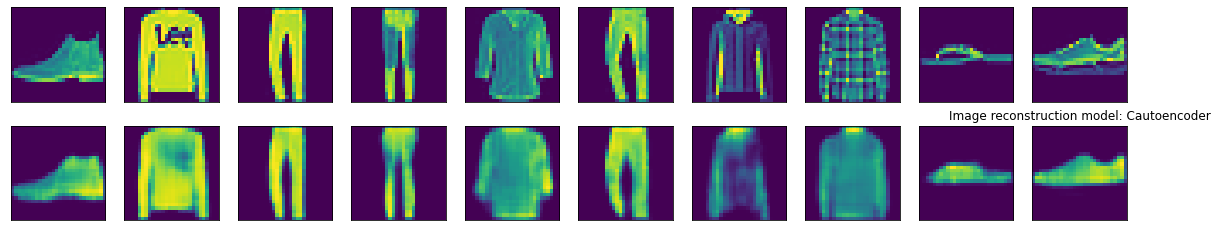

Instructions for updating:
Please use `layer.add_weight` method instead.
Epoch 1/5
469/469 [==============================] - 44s 93ms/step - loss: 0.0130
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0128
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0128
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0128
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0127
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0130
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0129
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0128
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0128
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0127
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0132
Epoch 2/5
469/469 [================

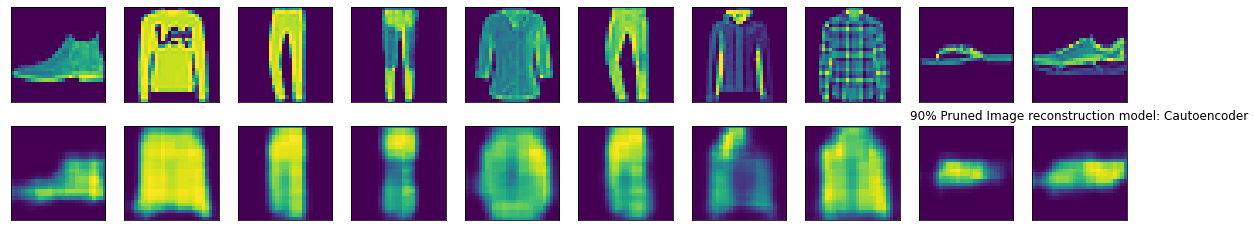

Epoch 1/200
47/47 [==============================] - 1s 15ms/step - loss: 0.1281 - val_loss: 0.0728
Epoch 2/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0490 - val_loss: 0.0351
Epoch 3/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0322 - val_loss: 0.0299
Epoch 4/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0285 - val_loss: 0.0272
Epoch 5/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0264 - val_loss: 0.0254
Epoch 6/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0248 - val_loss: 0.0241
Epoch 7/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0236 - val_loss: 0.0230
Epoch 8/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0227 - val_loss: 0.0222
Epoch 9/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0219 - val_loss: 0.0216
Epoch 10/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0213 - val_loss: 0.0211

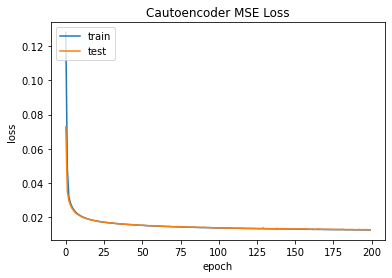

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Cautoencoder/assets
i=  1
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0129
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0127
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0127
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0127
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0126
Epoch 1/5
469/469 [==============================] - 4s 10ms/step - loss: 0.0129
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0127
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0127
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0127
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0126
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0

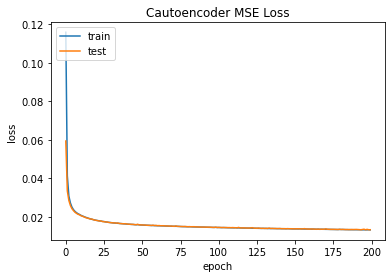

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Cautoencoder/assets
i=  2
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0136
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0132
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0131
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0131
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0130
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0136
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0132
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0131
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0131
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0130
Epoch 1/5
469/469 [==============================] - 4s 9ms/step - loss: 0.

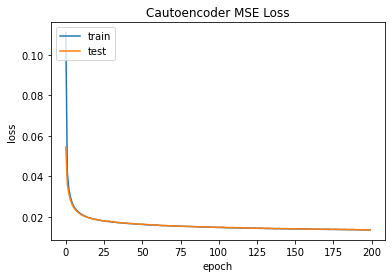

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Cautoencoder/assets
i=  3
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0138
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0136
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0136
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0135
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0135
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0138
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0137
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0136
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0135
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0135
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0

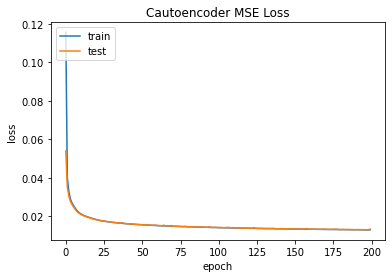

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Cautoencoder/assets
i=  4
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0133
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0129
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0129
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0128
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0128
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0133
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0129
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0129
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0128
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0128
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0

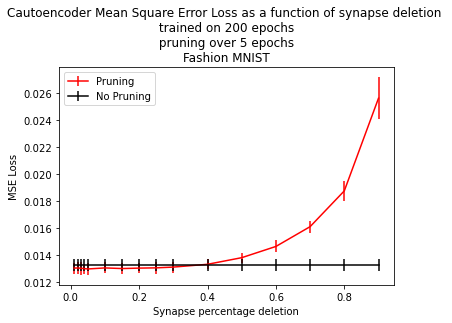

In [ ]:
x_train = x_train.reshape(len(x_train), 28,28,1)
x_test = x_test.reshape(len(x_test), 28,28,1)


synapse_deletion2, error_mean2, error_bar2, err_nopruning_mean2, err_nopruning_bar2 = run_train_and_prune('Cautoencoder', 'unsupervised', x_train, y_train, x_test, y_test, iterations=5, epochs=200, epochs_prun=5, dataset='Fashion MNIST')

Epoch 1/50
47/47 [==============================] - 1s 15ms/step - loss: 0.1292 - val_loss: 0.0678
Epoch 2/50
47/47 [==============================] - 1s 12ms/step - loss: 0.0438 - val_loss: 0.0339
Epoch 3/50
47/47 [==============================] - 1s 12ms/step - loss: 0.0313 - val_loss: 0.0290
Epoch 4/50
47/47 [==============================] - 1s 12ms/step - loss: 0.0278 - val_loss: 0.0265
Epoch 5/50
47/47 [==============================] - 1s 12ms/step - loss: 0.0258 - val_loss: 0.0250
Epoch 6/50
47/47 [==============================] - 1s 11ms/step - loss: 0.0244 - val_loss: 0.0238
Epoch 7/50
47/47 [==============================] - 1s 12ms/step - loss: 0.0235 - val_loss: 0.0230
Epoch 8/50
47/47 [==============================] - 1s 11ms/step - loss: 0.0227 - val_loss: 0.0224
Epoch 9/50
47/47 [==============================] - 1s 11ms/step - loss: 0.0221 - val_loss: 0.0218
Epoch 10/50
47/47 [==============================] - 1s 12ms/step - loss: 0.0216 - val_loss: 0.0216
Epoch 11/

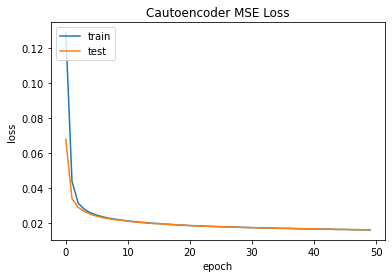

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Cautoencoder/assets
i=  0


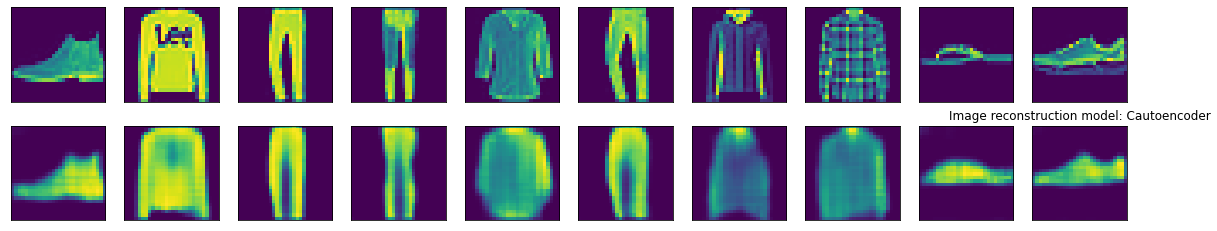

Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0165
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0157
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0155
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0153
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0150
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0165
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0157
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0155
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0152
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0150
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0165
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0157
Epoch 3/5
469/469 [=========

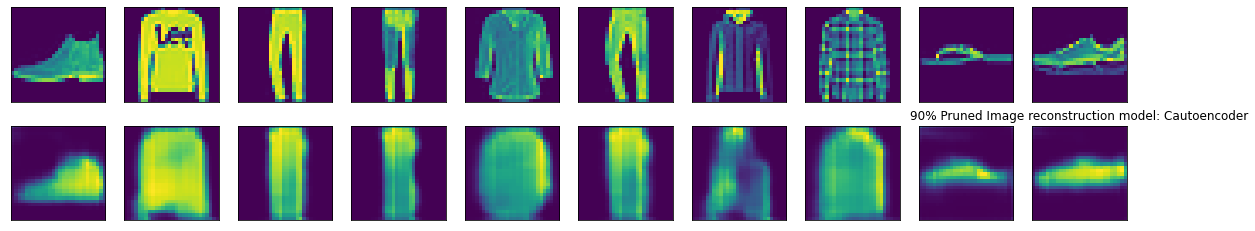

Epoch 1/50
47/47 [==============================] - 1s 14ms/step - loss: 0.1120 - val_loss: 0.0566
Epoch 2/50
47/47 [==============================] - 1s 11ms/step - loss: 0.0413 - val_loss: 0.0344
Epoch 3/50
47/47 [==============================] - 1s 12ms/step - loss: 0.0322 - val_loss: 0.0303
Epoch 4/50
47/47 [==============================] - 1s 12ms/step - loss: 0.0289 - val_loss: 0.0274
Epoch 5/50
47/47 [==============================] - 1s 12ms/step - loss: 0.0265 - val_loss: 0.0255
Epoch 6/50
47/47 [==============================] - 1s 11ms/step - loss: 0.0248 - val_loss: 0.0241
Epoch 7/50
47/47 [==============================] - 1s 12ms/step - loss: 0.0235 - val_loss: 0.0230
Epoch 8/50
47/47 [==============================] - 1s 11ms/step - loss: 0.0226 - val_loss: 0.0222
Epoch 9/50
47/47 [==============================] - 1s 11ms/step - loss: 0.0218 - val_loss: 0.0216
Epoch 10/50
47/47 [==============================] - 1s 12ms/step - loss: 0.0213 - val_loss: 0.0210
Epoch 11/

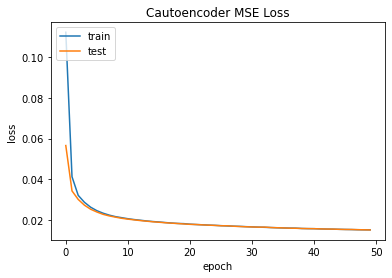

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Cautoencoder/assets
i=  1
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0154
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0150
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0147
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0145
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0144
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0155
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0150
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0148
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0146
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0144
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0

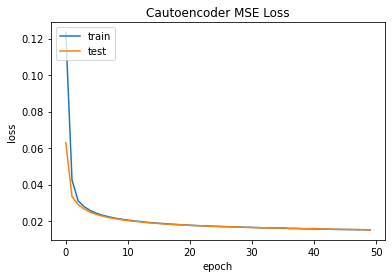

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Cautoencoder/assets
i=  2
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0154
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0149
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0146
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0143
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0141
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0153
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0148
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0146
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0143
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0141
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0

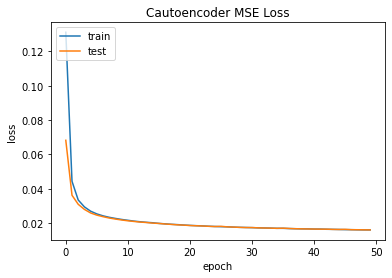

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Cautoencoder/assets
i=  3
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0165
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0158
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0156
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0154
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0152
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0165
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0158
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0156
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0154
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0152
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0

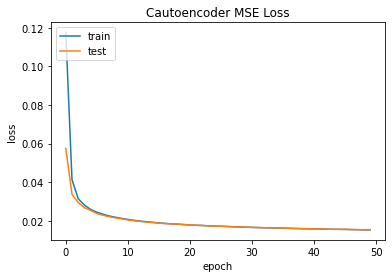

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Cautoencoder/assets
i=  4
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0156
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0150
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0148
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0146
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0144
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0157
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0151
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0148
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0146
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0144
Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0

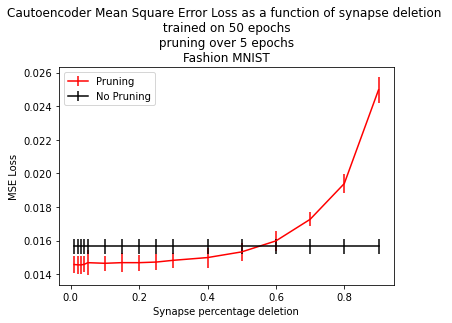

In [ ]:
x_train = x_train.reshape(len(x_train), 28,28,1)
x_test = x_test.reshape(len(x_test), 28,28,1)


synapse_deletion2, error_mean2, error_bar2, err_nopruning_mean2, err_nopruning_bar2 = run_train_and_prune('Cautoencoder', 'unsupervised', x_train, y_train, x_test, y_test, iterations=5, epochs=50, epochs_prun=5, dataset='Fashion MNIST')

Epoch 1/200
47/47 [==============================] - 35s 748ms/step - loss: 0.1254 - val_loss: 0.0720
Epoch 2/200
47/47 [==============================] - 1s 13ms/step - loss: 0.0454 - val_loss: 0.0357
Epoch 3/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0333 - val_loss: 0.0311
Epoch 4/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0297 - val_loss: 0.0283
Epoch 5/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0275 - val_loss: 0.0268
Epoch 6/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0261 - val_loss: 0.0256
Epoch 7/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0250 - val_loss: 0.0245
Epoch 8/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0242 - val_loss: 0.0237
Epoch 9/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0234 - val_loss: 0.0230
Epoch 10/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0228 - val_loss: 0.02

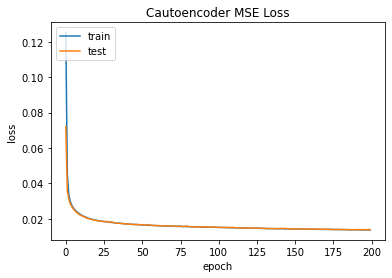

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Cautoencoder/assets
i=  0


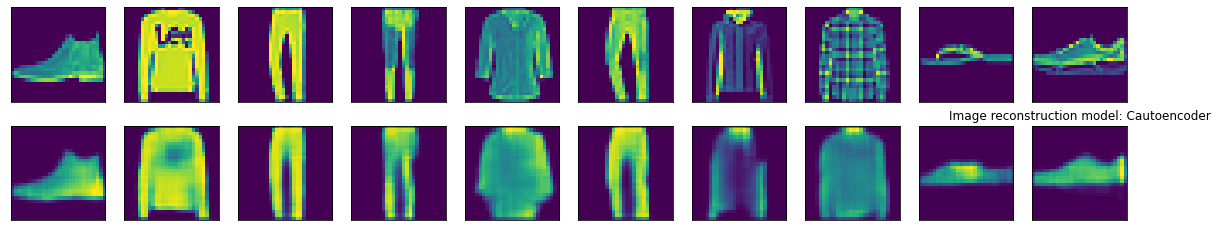

Instructions for updating:
Please use `layer.add_weight` method instead.
Epoch 1/25
469/469 [==============================] - 37s 78ms/step - loss: 0.0142
Epoch 2/25
469/469 [==============================] - 4s 9ms/step - loss: 0.0137
Epoch 3/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0137
Epoch 4/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0136
Epoch 5/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0136
Epoch 6/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0135
Epoch 7/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0135
Epoch 8/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0134
Epoch 9/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0134
Epoch 10/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0133
Epoch 11/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0132
Epoch 12/25
469/469 [==

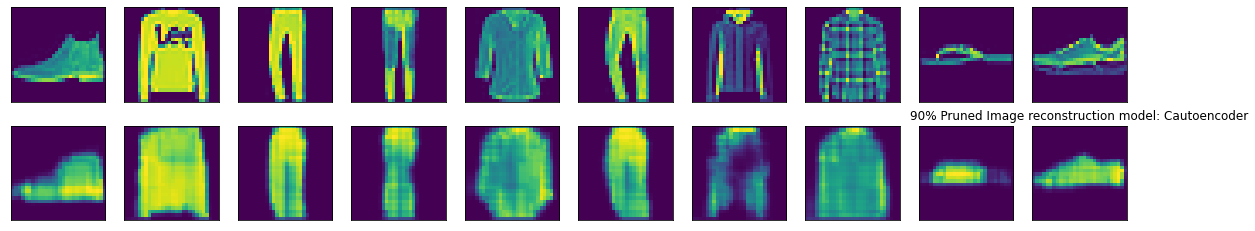

Epoch 1/200
47/47 [==============================] - 1s 15ms/step - loss: 0.1136 - val_loss: 0.0472
Epoch 2/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0387 - val_loss: 0.0337
Epoch 3/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0314 - val_loss: 0.0294
Epoch 4/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0282 - val_loss: 0.0270
Epoch 5/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0263 - val_loss: 0.0254
Epoch 6/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0250 - val_loss: 0.0243
Epoch 7/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0239 - val_loss: 0.0233
Epoch 8/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0229 - val_loss: 0.0225
Epoch 9/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0222 - val_loss: 0.0218
Epoch 10/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0215 - val_loss: 0.0212

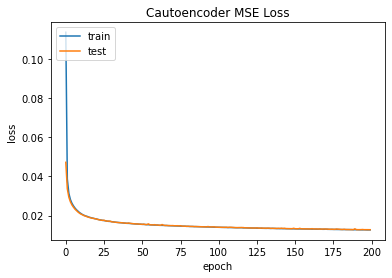

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Cautoencoder/assets
i=  1
Epoch 1/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0131
Epoch 2/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0126
Epoch 3/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0126
Epoch 4/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0125
Epoch 5/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0125
Epoch 6/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0124
Epoch 7/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0123
Epoch 8/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0123
Epoch 9/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0122
Epoch 10/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0122
Epoch 11/25
469/469 [==============================] - 5s 10ms/s

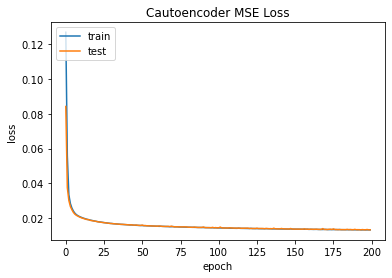

INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Cautoencoder/assets
i=  2
Epoch 1/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0138
Epoch 2/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0133
Epoch 3/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0132
Epoch 4/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0132
Epoch 5/25
469/469 [==============================] - 4s 9ms/step - loss: 0.0132
Epoch 6/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0131
Epoch 7/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0131
Epoch 8/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0130
Epoch 9/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0130
Epoch 10/25
469/469 [==============================] - 5s 10ms/step - loss: 0.0130
Epoch 11/25
469/469 [==============================] - 5s 10ms/st

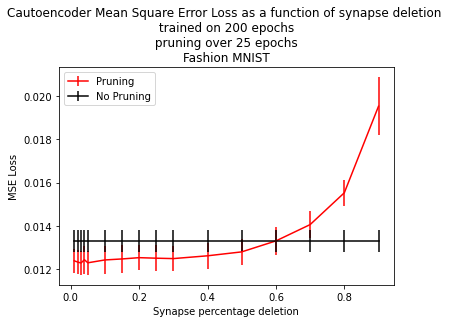

In [ ]:
x_train = x_train.reshape(len(x_train), 28,28,1)
x_test = x_test.reshape(len(x_test), 28,28,1)


synapse_deletion2, error_mean2, error_bar2, err_nopruning_mean2, err_nopruning_bar2 = run_train_and_prune('Cautoencoder', 'unsupervised', x_train, y_train, x_test, y_test, iterations=3, epochs=200, epochs_prun=25, dataset='Fashion MNIST')

## CIFAR10 dataset

In [ ]:
def prepare_cifar10_data(subtract_pixel_mean = True):

    #load cifar10 data and returns the data in the format required

    # The data, split between train and test sets:
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    # Normalize data.
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    num_classes=10
    # If subtract pixel mean is enabled (Subtracting pixel mean improves accuracy)
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean

    # Convert class vectors to binary class matrices.
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return (x_train, y_train),(x_test,y_test)

(x_train_cifar, y_train_cifar),(x_test_cifar, y_test_cifar) = prepare_cifar10_data()

### CNN

Learning rate:  0.001
Learning rate:  0.001
Epoch 1/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.2841 - accuracy: 0.5390 - val_loss: 0.9688 - val_accuracy: 0.6622 - lr: 0.0010
Learning rate:  0.001
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8405 - accuracy: 0.7068 - val_loss: 0.8112 - val_accuracy: 0.7183 - lr: 0.0010
Learning rate:  0.001
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6453 - accuracy: 0.7748 - val_loss: 0.7255 - val_accuracy: 0.7502 - lr: 0.0010
Learning rate:  0.001
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.4983 - accuracy: 0.8272 - val_loss: 0.7464 - val_accuracy: 0.7500 - lr: 0.0010
Learning rate:  0.001
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3630 - accuracy: 0.8714 - val_loss: 0.8027 - val_accuracy: 0.7512 - lr: 0.0010
Learning rate:  0.001
Epoch 6/10
1563/1563 [==============================] - 6s 

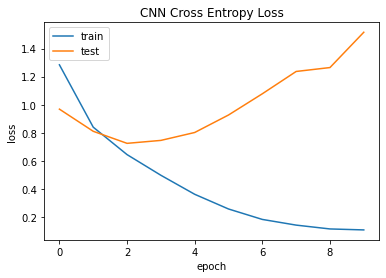

313/313 [==============================] - 1s 3ms/step - loss: 1.5159 - accuracy: 0.7388
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  0
Instructions for updating:
Please use `layer.add_weight` method instead.
391/391 [==============================] - 5s 13ms/step - loss: 0.4385 - val_loss: 0.9445
Learning rate:  0.001
Learning rate:  0.001
Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2779 - accuracy: 0.5413 - val_loss: 0.9885 - val_accuracy: 0.6524 - lr: 0.0010
Learning rate:  0.001
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8279 - accuracy: 0.7114 - val_loss: 0.8125 - val_accuracy: 0.7202 - lr: 0.0010
Learning rate:  0.001
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0

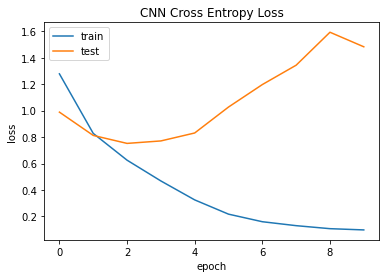

313/313 [==============================] - 1s 2ms/step - loss: 1.4824 - accuracy: 0.7473
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  1
391/391 [==============================] - 5s 13ms/step - loss: 0.4269 - val_loss: 0.9375
Learning rate:  0.001
Learning rate:  0.001
Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2819 - accuracy: 0.5413 - val_loss: 1.0695 - val_accuracy: 0.6292 - lr: 0.0010
Learning rate:  0.001
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8260 - accuracy: 0.7089 - val_loss: 0.7982 - val_accuracy: 0.7230 - lr: 0.0010
Learning rate:  0.001
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6288 - accuracy: 0.7794 - val_loss: 0.7979 - val_accuracy: 0.7320 - lr: 0.0010
Learning rate:  0.001
Epoch 4/10
1563/1563 [==============================

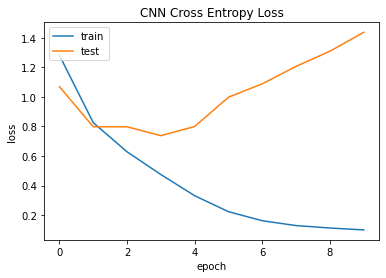

313/313 [==============================] - 1s 2ms/step - loss: 1.4376 - accuracy: 0.7432
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  2
391/391 [==============================] - 5s 13ms/step - loss: 0.4235 - val_loss: 0.9798
Learning rate:  0.001
Learning rate:  0.001
Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2732 - accuracy: 0.5432 - val_loss: 0.9450 - val_accuracy: 0.6643 - lr: 0.0010
Learning rate:  0.001
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8226 - accuracy: 0.7132 - val_loss: 0.8142 - val_accuracy: 0.7141 - lr: 0.0010
Learning rate:  0.001
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6273 - accuracy: 0.7793 - val_loss: 0.7442 - val_accuracy: 0.7464 - lr: 0.0010
Learning rate:  0.001
Epoch 4/10
1563/1563 [==============================

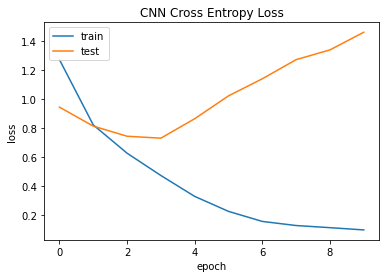

313/313 [==============================] - 1s 2ms/step - loss: 1.4618 - accuracy: 0.7516
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  3
391/391 [==============================] - 5s 13ms/step - loss: 0.3974 - val_loss: 0.9086
Learning rate:  0.001
Learning rate:  0.001
Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2926 - accuracy: 0.5362 - val_loss: 1.0197 - val_accuracy: 0.6385 - lr: 0.0010
Learning rate:  0.001
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8308 - accuracy: 0.7085 - val_loss: 0.8083 - val_accuracy: 0.7208 - lr: 0.0010
Learning rate:  0.001
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6221 - accuracy: 0.7816 - val_loss: 0.7546 - val_accuracy: 0.7449 - lr: 0.0010
Learning rate:  0.001
Epoch 4/10
1563/1563 [==============================

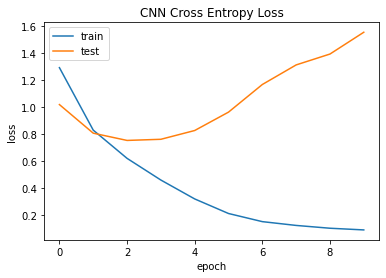

313/313 [==============================] - 1s 2ms/step - loss: 1.5544 - accuracy: 0.7372
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  4
391/391 [==============================] - 5s 13ms/step - loss: 0.4287 - val_loss: 0.9299


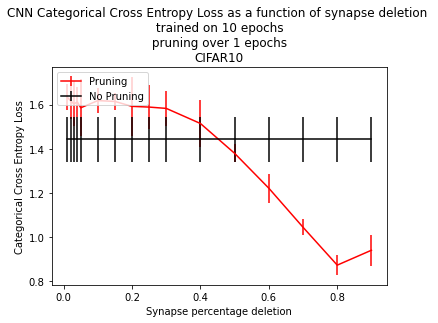

In [ ]:
synapse_deletion3, error_mean3, error_bar3, err_nopruning_mean3, err_nopruning_bar3 = run_train_and_prune('CNN', 'supervised',
                                            x_train_cifar, y_train_cifar,
                        x_test_cifar, y_test_cifar, iterations=5, epochs=10, epochs_prun=1, dataset='CIFAR10')

Learning rate:  0.001
Learning rate:  0.001
Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2900 - accuracy: 0.5365 - val_loss: 1.0360 - val_accuracy: 0.6239 - lr: 0.0010
Learning rate:  0.001
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8337 - accuracy: 0.7067 - val_loss: 0.8152 - val_accuracy: 0.7146 - lr: 0.0010
Learning rate:  0.001
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6344 - accuracy: 0.7768 - val_loss: 0.8103 - val_accuracy: 0.7218 - lr: 0.0010
Learning rate:  0.001
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.4740 - accuracy: 0.8331 - val_loss: 0.7801 - val_accuracy: 0.7481 - lr: 0.0010
Learning rate:  0.001
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3299 - accuracy: 0.8857 - val_loss: 0.7975 - val_accuracy: 0.7555 - lr: 0.0010
Learning rate:  0.001
Epoch 6/10
1563/1563 [==============================] - 6s 4m

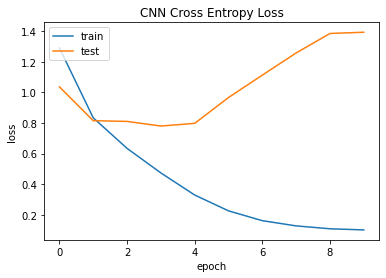

313/313 [==============================] - 1s 2ms/step - loss: 1.3924 - accuracy: 0.7474
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  0
Epoch 1/5
391/391 [==============================] - 5s 14ms/step - loss: 0.0400 - val_loss: 1.6425
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0168 - val_loss: 1.8664
Epoch 3/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0218 - val_loss: 1.9316
Epoch 4/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0232 - val_loss: 1.8555
Epoch 5/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0217 - val_loss: 1.9942
Epoch 1/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0404 - val_loss: 1.6420
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0163 - val_loss: 1.9313
Epoch 3/5
391/391 [====

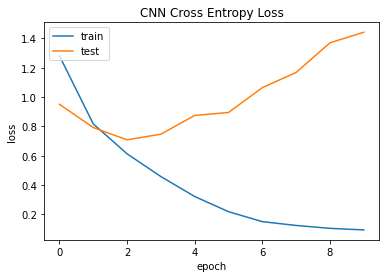

313/313 [==============================] - 1s 2ms/step - loss: 1.4425 - accuracy: 0.7495
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  1
Epoch 1/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0362 - val_loss: 1.5814
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0176 - val_loss: 1.8057
Epoch 3/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0221 - val_loss: 1.9293
Epoch 4/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0243 - val_loss: 1.8386
Epoch 5/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0181 - val_loss: 1.9292
Epoch 1/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0345 - val_loss: 1.6329
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0166 - val_loss: 1.7931
Epoch 3/5
391/391 [====

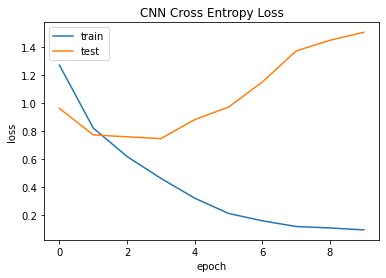

313/313 [==============================] - 1s 3ms/step - loss: 1.5030 - accuracy: 0.7406
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  2
Epoch 1/5
391/391 [==============================] - 5s 14ms/step - loss: 0.0347 - val_loss: 1.7196
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0261 - val_loss: 1.7871
Epoch 3/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0187 - val_loss: 1.9863
Epoch 4/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0147 - val_loss: 2.1266
Epoch 5/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0224 - val_loss: 2.0263
Epoch 1/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0379 - val_loss: 1.7066
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0175 - val_loss: 1.8632
Epoch 3/5
391/391 [====

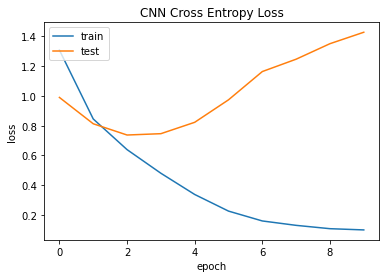

313/313 [==============================] - 1s 2ms/step - loss: 1.4278 - accuracy: 0.7512
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  3
Epoch 1/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0343 - val_loss: 1.7033
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0204 - val_loss: 1.8231
Epoch 3/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0214 - val_loss: 1.9558
Epoch 4/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0186 - val_loss: 2.0392
Epoch 5/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0356 - val_loss: 1.9334
Epoch 1/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0343 - val_loss: 1.6771
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0195 - val_loss: 1.8862
Epoch 3/5
391/391 [====

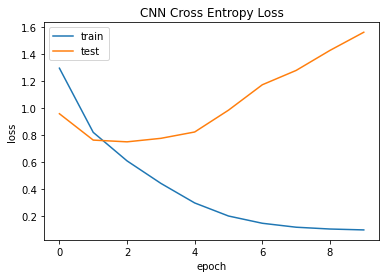

313/313 [==============================] - 1s 2ms/step - loss: 1.5613 - accuracy: 0.7442
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  4
Epoch 1/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0370 - val_loss: 1.6911
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0193 - val_loss: 1.8212
Epoch 3/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0194 - val_loss: 1.8855
Epoch 4/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0149 - val_loss: 2.0212
Epoch 5/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0187 - val_loss: 2.0249
Epoch 1/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0341 - val_loss: 1.8029
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0223 - val_loss: 1.8295
Epoch 3/5
391/391 [====

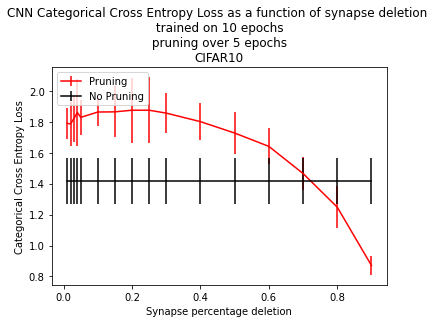

In [ ]:
synapse_deletion7, error_mean7, error_bar7, err_nopruning_mean7, err_nopruning_bar7 = run_train_and_prune('CNN', 'supervised',
                                            x_train_cifar, y_train_cifar,
                        x_test_cifar, y_test_cifar, iterations=5, epochs=10, epochs_prun=5, dataset='CIFAR10')

Learning rate:  0.001
Learning rate:  0.001
Epoch 1/50
1563/1563 [==============================] - 20s 13ms/step - loss: 1.2741 - accuracy: 0.5414 - val_loss: 0.9304 - val_accuracy: 0.6756 - lr: 0.0010
Learning rate:  0.001
Epoch 2/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8252 - accuracy: 0.7110 - val_loss: 0.8864 - val_accuracy: 0.6962 - lr: 0.0010
Learning rate:  0.001
Epoch 3/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6281 - accuracy: 0.7791 - val_loss: 0.7230 - val_accuracy: 0.7506 - lr: 0.0010
Learning rate:  0.001
Epoch 4/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.4692 - accuracy: 0.8349 - val_loss: 0.7411 - val_accuracy: 0.7545 - lr: 0.0010
Learning rate:  0.001
Epoch 5/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3318 - accuracy: 0.8827 - val_loss: 0.8719 - val_accuracy: 0.7497 - lr: 0.0010
Learning rate:  0.001
Epoch 6/50
1563/1563 [==============================] - 6s 

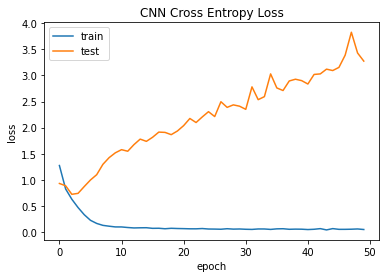

313/313 [==============================] - 1s 2ms/step - loss: 3.2740 - accuracy: 0.7399
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  0
Instructions for updating:
Please use `layer.add_weight` method instead.
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3315 - accuracy: 0.8834 - val_loss: 0.8172 - val_accuracy: 0.7526 - lr: 0.0010
Learning rate:  0.001
Epoch 6/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2229 - accuracy: 0.9224 - val_loss: 1.0081 - val_accuracy: 0.7438 - lr: 0.0010
Learning rate:  0.001
Epoch 7/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1571 - accuracy: 0.9463 - val_loss: 1.1619 - val_accuracy: 0.7449 - lr: 0.0010
Learning rate:  0.001
Epoch 8/50
1563/1563 [=====================

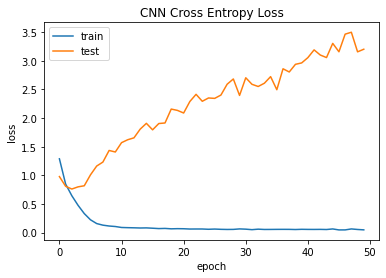

313/313 [==============================] - 1s 2ms/step - loss: 3.2024 - accuracy: 0.7341
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  1
391/391 [==============================] - 5s 13ms/step - loss: 0.7309 - val_loss: 1.4513
Learning rate:  0.001
Learning rate:  0.001
Epoch 1/50
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2865 - accuracy: 0.5363 - val_loss: 0.9187 - val_accuracy: 0.6761 - lr: 0.0010
Learning rate:  0.001
Epoch 2/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8193 - accuracy: 0.7123 - val_loss: 0.7800 - val_accuracy: 0.7288 - lr: 0.0010
Learning rate:  0.001
Epoch 3/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6182 - accuracy: 0.7832 - val_loss: 0.7710 - val_accuracy: 0.7402 - lr: 0.0010
Learning rate:  0.001
Epoch 4/50
1563/1563 [==============================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1563/1563 [==============================] - 6s 4ms/step - loss: 0.0613 - accuracy: 0.9827 - val_loss: 2.3473 - val_accuracy: 0.7434 - lr: 0.0010
Learning rate:  0.001
Epoch 27/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0562 - accuracy: 0.9835 - val_loss: 2.2707 - val_accuracy: 0.7489 - lr: 0.0010
Learning rate:  0.001
Epoch 28/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0596 - accuracy: 0.9835 - val_loss: 2.4241 - val_accuracy: 0.7410 - lr: 0.0010
Learning rate:  0.001
Epoch 29/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0571 - accuracy: 0.9840 - val_loss: 2.4679 - val_accuracy: 0.7378 - lr: 3.1623e-04
Learning rate:  0.001
Epoch 30/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0525 - accuracy: 0.9860 - val_loss: 2.5653 - val_accuracy: 0.7371 - lr: 0.0010
Learning rate:  0.001
Epoch 31/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0569 - accuracy: 0.9843 - val

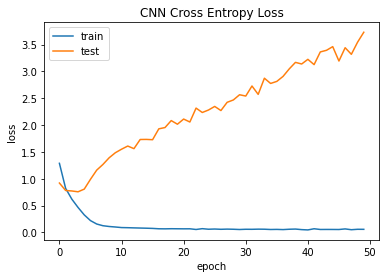

313/313 [==============================] - 1s 2ms/step - loss: 3.7309 - accuracy: 0.7396
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  2
391/391 [==============================] - 5s 13ms/step - loss: 0.7748 - val_loss: 1.4739
Learning rate:  0.001
Learning rate:  0.001
Epoch 1/50
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2830 - accuracy: 0.5353 - val_loss: 0.9719 - val_accuracy: 0.6559 - lr: 0.0010
Learning rate:  0.001
Epoch 2/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8132 - accuracy: 0.7162 - val_loss: 0.8459 - val_accuracy: 0.7084 - lr: 0.0010
Learning rate:  0.001
Epoch 3/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6086 - accuracy: 0.7878 - val_loss: 0.7160 - val_accuracy: 0.7539 - lr: 0.0010
Learning rate:  0.001
Epoch 4/50
1563/1563 [==============================

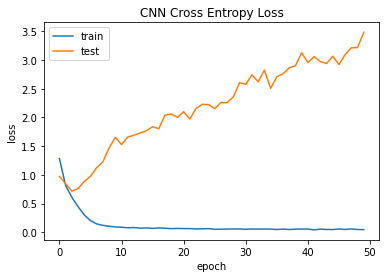

313/313 [==============================] - 1s 2ms/step - loss: 3.4860 - accuracy: 0.7373
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  3
391/391 [==============================] - 5s 13ms/step - loss: 0.7996 - val_loss: 1.4824
Learning rate:  0.001
Learning rate:  0.001
Epoch 1/50
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2596 - accuracy: 0.5459 - val_loss: 0.9531 - val_accuracy: 0.6695 - lr: 0.0010
Learning rate:  0.001
Epoch 2/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8081 - accuracy: 0.7178 - val_loss: 0.7857 - val_accuracy: 0.7264 - lr: 0.0010
Learning rate:  0.001
Epoch 3/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6234 - accuracy: 0.7823 - val_loss: 0.7189 - val_accuracy: 0.7499 - lr: 0.0010
Learning rate:  0.001
Epoch 4/50
1563/1563 [==============================

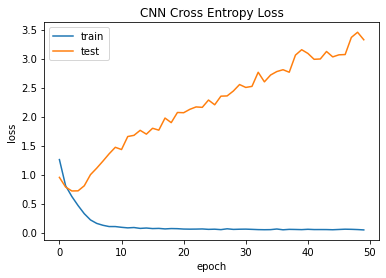

313/313 [==============================] - 1s 2ms/step - loss: 3.3256 - accuracy: 0.7440
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  4
391/391 [==============================] - 5s 13ms/step - loss: 0.7589 - val_loss: 1.4281


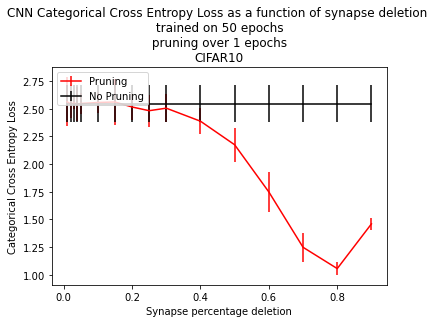

In [ ]:
synapse_deletion5, error_mean5, error_bar5, err_nopruning_mean5, err_nopruning_bar5 = run_train_and_prune('CNN', 'supervised',
                                            x_train_cifar, y_train_cifar,
                        x_test_cifar, y_test_cifar, iterations=5, epochs=50, epochs_prun=1, dataset='CIFAR10')

Learning rate:  0.001
Learning rate:  0.001
Epoch 1/50
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2755 - accuracy: 0.5418 - val_loss: 0.9894 - val_accuracy: 0.6560 - lr: 0.0010
Learning rate:  0.001
Epoch 2/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8175 - accuracy: 0.7137 - val_loss: 0.8006 - val_accuracy: 0.7249 - lr: 0.0010
Learning rate:  0.001
Epoch 3/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6231 - accuracy: 0.7807 - val_loss: 0.7134 - val_accuracy: 0.7602 - lr: 0.0010
Learning rate:  0.001
Epoch 4/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.4660 - accuracy: 0.8362 - val_loss: 0.7512 - val_accuracy: 0.7626 - lr: 0.0010
Learning rate:  0.001
Epoch 5/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3325 - accuracy: 0.8837 - val_loss: 0.8011 - val_accuracy: 0.7544 - lr: 0.0010
Learning rate:  0.001
Epoch 6/50
1563/1563 [==============================] - 6s 4m

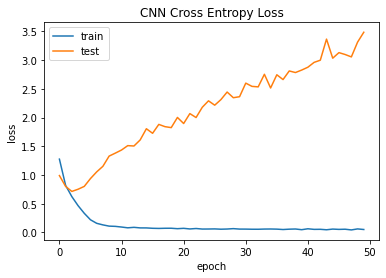

313/313 [==============================] - 1s 2ms/step - loss: 3.4859 - accuracy: 0.7452
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  0
Epoch 1/5
391/391 [==============================] - 6s 15ms/step - loss: 0.0160 - val_loss: 3.5559
Epoch 2/5
391/391 [==============================] - 6s 15ms/step - loss: 0.0110 - val_loss: 3.7996
Epoch 3/5
391/391 [==============================] - 6s 14ms/step - loss: 0.0137 - val_loss: 4.1174
Epoch 4/5
391/391 [==============================] - 6s 15ms/step - loss: 0.0127 - val_loss: 4.0258
Epoch 5/5
391/391 [==============================] - 6s 15ms/step - loss: 0.0211 - val_loss: 3.8840
Epoch 1/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0173 - val_loss: 3.3599
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0092 - val_loss: 3.5624
Epoch 3/5
391/391 [====

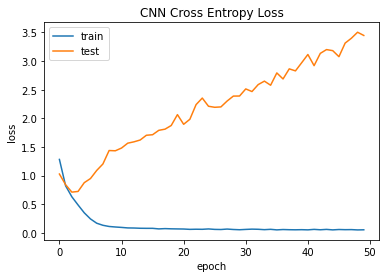

313/313 [==============================] - 1s 2ms/step - loss: 3.4478 - accuracy: 0.7397
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  1
Epoch 1/5
391/391 [==============================] - 5s 14ms/step - loss: 0.0194 - val_loss: 3.5362
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0084 - val_loss: 3.7505
Epoch 3/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0180 - val_loss: 3.9814
Epoch 4/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0133 - val_loss: 4.2498
Epoch 5/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0144 - val_loss: 4.0033
Epoch 1/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0226 - val_loss: 3.5547
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0079 - val_loss: 3.5805
Epoch 3/5
391/391 [====

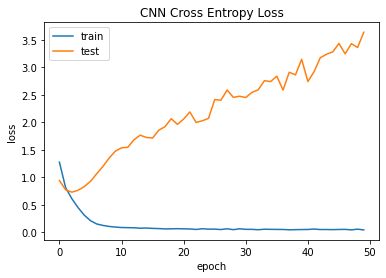

313/313 [==============================] - 1s 2ms/step - loss: 3.6406 - accuracy: 0.7378
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  2
Epoch 1/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0176 - val_loss: 3.7046
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0099 - val_loss: 4.1358
Epoch 3/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0146 - val_loss: 4.0921
Epoch 4/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0180 - val_loss: 4.2118
Epoch 5/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0149 - val_loss: 4.1621
Epoch 1/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0207 - val_loss: 3.6648
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0112 - val_loss: 4.0417
Epoch 3/5
391/391 [====

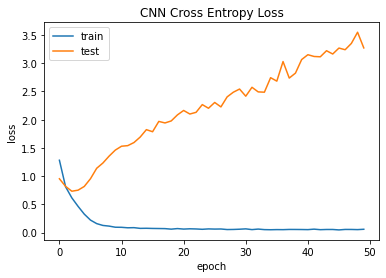

313/313 [==============================] - 1s 2ms/step - loss: 3.2712 - accuracy: 0.7473
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  3
Epoch 1/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0220 - val_loss: 3.5661
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0088 - val_loss: 3.7029
Epoch 3/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0155 - val_loss: 3.9371
Epoch 4/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0159 - val_loss: 3.9046
Epoch 5/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0123 - val_loss: 3.9356
Epoch 1/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0180 - val_loss: 3.7535
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0105 - val_loss: 3.8786
Epoch 3/5
391/391 [====

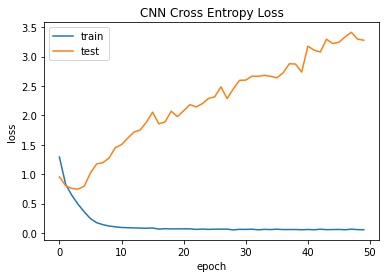

313/313 [==============================] - 1s 2ms/step - loss: 3.2792 - accuracy: 0.7386
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/CNN 
i=  4
Epoch 1/5
391/391 [==============================] - 5s 14ms/step - loss: 0.0211 - val_loss: 3.4191
Epoch 2/5
391/391 [==============================] - 5s 14ms/step - loss: 0.0100 - val_loss: 3.6954
Epoch 3/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0095 - val_loss: 3.9595
Epoch 4/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0118 - val_loss: 4.1443
Epoch 5/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0221 - val_loss: 3.9833
Epoch 1/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0198 - val_loss: 3.4286
Epoch 2/5
391/391 [==============================] - 5s 13ms/step - loss: 0.0081 - val_loss: 3.6489
Epoch 3/5
391/391 [====

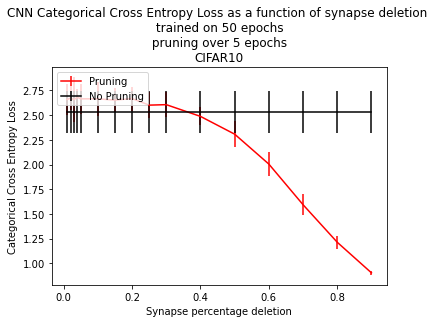

In [ ]:
synapse_deletion8, error_mean8, error_bar8, err_nopruning_mean8, err_nopruning_bar8 = run_train_and_prune('CNN', 'supervised',
                                            x_train_cifar, y_train_cifar,
                        x_test_cifar, y_test_cifar, iterations=5, epochs=50, epochs_prun=5, dataset='CIFAR10')

## Resnet

Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Epoch 1/10
1563/1563 [==============================] - 153s 98ms/step - loss: 1.4700 - accuracy: 0.5294 - val_loss: 1.4624 - val_accuracy: 0.5629 - lr: 0.0010
Learning rate:  0.001
Epoch 2/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.0455 - accuracy: 0.6923 - val_loss: 1.1561 - val_accuracy: 0.6614 - lr: 0.0010
Learning rate:  0.001
Epoch 3/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.8938 - accuracy: 0.7459 - val_loss: 1.0181 - val_accuracy: 0.6957 - lr: 0.0010
Learning rate:  0.001
Epoch 4/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.8025 - accuracy: 0.7817 - val_loss: 1.0124 - val_accuracy: 0.7186 - lr: 0.0010
Learning rate:  0.001
Epoch 5/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.7423 - accuracy: 0.8033 - val_loss: 1.0745 - val_accuracy: 0.7089 - lr: 0.0010
Learning rate:  0.001
Epoch 6/10
1563/1563 [==========

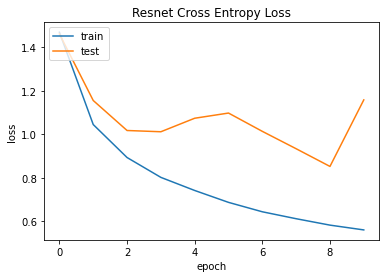

313/313 [==============================] - 1s 4ms/step - loss: 1.1588 - accuracy: 0.7191
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet 
i=  0
391/391 [==============================] - 19s 47ms/step - loss: 0.8652 - val_loss: 2.0166
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Epoch 1/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.4986 - accuracy: 0.5131 - val_loss: 1.4073 - val_accuracy: 0.5715 - lr: 0.0010
Learning rate:  0.001
Epoch 2/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.0827 - accuracy: 0.6720 - val_loss: 1.3015 - val_accuracy: 0.6178 - lr: 0.0010
Learning rate:  0.001
Epoch 3/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.9064 - accuracy: 0.7395 - val_loss: 1.0322 - val_accuracy: 0.6993 - lr: 0.0010
Learning rate:  0.001
Epoch 4/10
1563/156

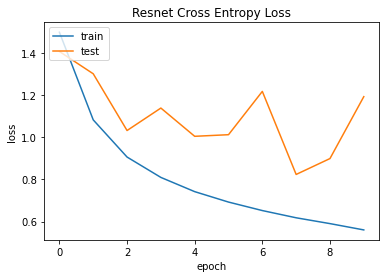

313/313 [==============================] - 1s 4ms/step - loss: 1.1929 - accuracy: 0.6995
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet 
i=  1
391/391 [==============================] - 19s 48ms/step - loss: 0.8091 - val_loss: 2.7693
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Epoch 1/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.5119 - accuracy: 0.5096 - val_loss: 1.9389 - val_accuracy: 0.4043 - lr: 0.0010
Learning rate:  0.001
Epoch 2/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.0923 - accuracy: 0.6731 - val_loss: 1.1831 - val_accuracy: 0.6451 - lr: 0.0010
Learning rate:  0.001
Epoch 3/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.9159 - accuracy: 0.7368 - val_loss: 1.0318 - val_accuracy: 0.6991 - lr: 0.0010
Learning rate:  0.001
Epoch 4/10
1563/1

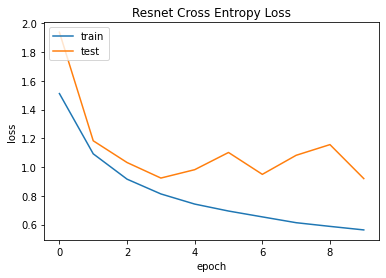

313/313 [==============================] - 1s 4ms/step - loss: 0.9199 - accuracy: 0.7747
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet 
i=  2
391/391 [==============================] - 19s 48ms/step - loss: 0.8205 - val_loss: 2.5067


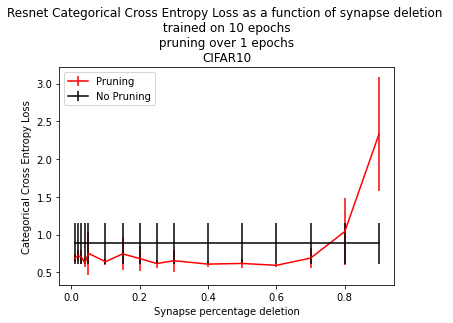

In [ ]:
synapse_deletion4, error_mean4, error_bar4, err_nopruning_mean4, err_nopruning_bar4 = run_train_and_prune('Resnet',
                                        'supervised', x_train_cifar, y_train_cifar,
                        x_test_cifar, y_test_cifar, iterations=3, epochs=10, epochs_prun=1, dataset='CIFAR10')

Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Epoch 1/10
1563/1563 [==============================] - 37s 24ms/step - loss: 1.4898 - accuracy: 0.5172 - val_loss: 1.4159 - val_accuracy: 0.5315 - lr: 0.0010
Learning rate:  0.001
Epoch 2/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.0768 - accuracy: 0.6774 - val_loss: 1.1946 - val_accuracy: 0.6514 - lr: 0.0010
Learning rate:  0.001
Epoch 3/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.9103 - accuracy: 0.7388 - val_loss: 1.2271 - val_accuracy: 0.6660 - lr: 0.0010
Learning rate:  0.001
Epoch 4/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.8102 - accuracy: 0.7758 - val_loss: 1.0254 - val_accuracy: 0.7208 - lr: 0.0010
Learning rate:  0.001
Epoch 5/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.7407 - accuracy: 0.8032 - val_loss: 0.9119 - val_accuracy: 0.7425 - lr: 0.0010
Learning rate:  0.001
Epoch 6/10
1563/1563 [===========

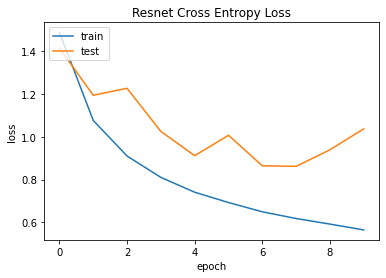

313/313 [==============================] - 1s 4ms/step - loss: 1.0377 - accuracy: 0.7520
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet 
i=  0
Instructions for updating:
Please use `layer.add_weight` method instead.
Epoch 1/5
391/391 [==============================] - 47s 121ms/step - loss: 0.4055 - val_loss: 0.8669
Epoch 2/5
391/391 [==============================] - 18s 46ms/step - loss: 0.3347 - val_loss: 0.9405
Epoch 3/5
391/391 [==============================] - 17s 44ms/step - loss: 0.3067 - val_loss: 2.0962
Epoch 4/5
391/391 [==============================] - 17s 44ms/step - loss: 0.2912 - val_loss: 1.2346
Epoch 5/5
391/391 [==============================] - 17s 44ms/step - loss: 0.2824 - val_loss: 1.6180
Epoch 1/5
391/391 [==============================] - 19s 

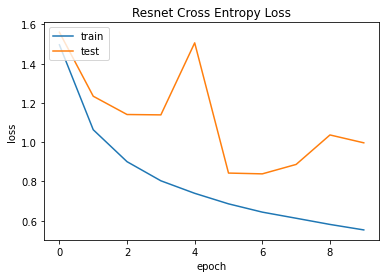

313/313 [==============================] - 1s 4ms/step - loss: 0.9970 - accuracy: 0.7497
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet 
i=  1
Epoch 1/5
391/391 [==============================] - 19s 48ms/step - loss: 0.3953 - val_loss: 0.9518
Epoch 2/5
391/391 [==============================] - 18s 46ms/step - loss: 0.3266 - val_loss: 1.0510
Epoch 3/5
391/391 [==============================] - 17s 44ms/step - loss: 0.3060 - val_loss: 1.1479
Epoch 4/5
391/391 [==============================] - 17s 45ms/step - loss: 0.2824 - val_loss: 1.2827
Epoch 5/5
391/391 [==============================] - 17s 44ms/step - loss: 0.2816 - val_loss: 1.3802
Epoch 1/5
391/391 [==============================] - 19s 48ms/step - loss: 0.3955 - val_loss: 0.8958
Epoch 2/5
391/391 [==============================] - 17s 44ms/step - loss: 0.3232 - val_loss: 0.9225
Epoch 3/5


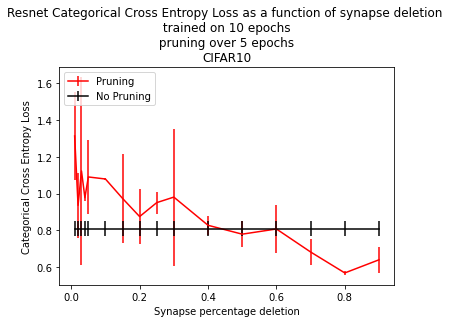

In [ ]:
synapse_deletion9, error_mean9, error_bar9, err_nopruning_mean9, err_nopruning_bar9 = run_train_and_prune('Resnet',
                                        'supervised', x_train_cifar, y_train_cifar,
                        x_test_cifar, y_test_cifar, iterations=2, epochs=10, epochs_prun=5, dataset='CIFAR10')

Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Epoch 1/50
1563/1563 [==============================] - 15s 10ms/step - loss: 1.4804 - accuracy: 0.5236 - val_loss: 3.3036 - val_accuracy: 0.3004 - lr: 0.0010
Learning rate:  0.001
Epoch 2/50
1563/1563 [==============================] - 14s 9ms/step - loss: 1.0587 - accuracy: 0.6837 - val_loss: 1.2640 - val_accuracy: 0.6415 - lr: 0.0010
Learning rate:  0.001
Epoch 3/50
1563/1563 [==============================] - 15s 9ms/step - loss: 0.8930 - accuracy: 0.7452 - val_loss: 1.0643 - val_accuracy: 0.6973 - lr: 0.0010
Learning rate:  0.001
Epoch 4/50
1563/1563 [==============================] - 14s 9ms/step - loss: 0.7958 - accuracy: 0.7821 - val_loss: 1.0103 - val_accuracy: 0.7107 - lr: 0.0010
Learning rate:  0.001
Epoch 5/50
1563/1563 [==============================] - 14s 9ms/step - loss: 0.7296 - accuracy: 0.8089 - val_loss: 1.1349 - val_accuracy: 0.6943 - lr: 0.0010
Learning rate:  0.001
Epoch 6/50
1563/1563 [===========

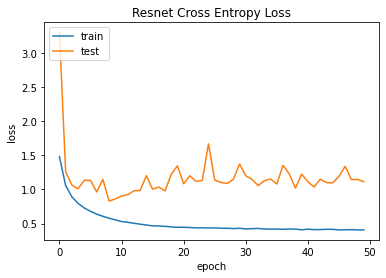

313/313 [==============================] - 1s 4ms/step - loss: 1.1132 - accuracy: 0.7953
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet 
i=  0
391/391 [==============================] - 19s 49ms/step - loss: 0.7372 - val_loss: 2.4000
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Epoch 1/50
1563/1563 [==============================] - 15s 10ms/step - loss: 1.5168 - accuracy: 0.5113 - val_loss: 1.4011 - val_accuracy: 0.5717 - lr: 0.0010
Learning rate:  0.001
Epoch 2/50
1563/1563 [==============================] - 14s 9ms/step - loss: 1.0952 - accuracy: 0.6707 - val_loss: 1.2078 - val_accuracy: 0.6485 - lr: 0.0010
Learning rate:  0.001
Epoch 3/50
1563/1563 [==============================] - 14s 9ms/step - loss: 0.9204 - accuracy: 0.7373 - val_loss: 1.0356 - val_accuracy: 0.6924 - lr: 0.0010
Learning rate:  0.001
Epoch 4/50
1563/156

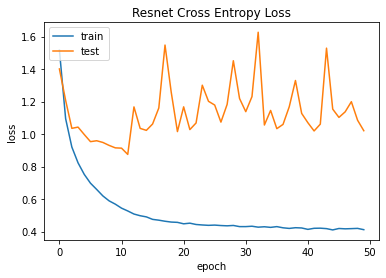

313/313 [==============================] - 1s 4ms/step - loss: 1.0209 - accuracy: 0.8114
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet 
i=  1
391/391 [==============================] - 19s 48ms/step - loss: 0.7406 - val_loss: 2.5204


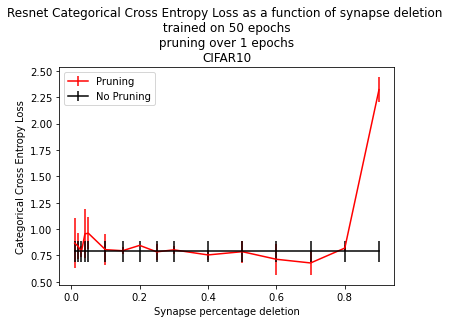

In [ ]:
synapse_deletion6, error_mean6, error_bar6, err_nopruning_mean6, err_nopruning_bar6 = run_train_and_prune('Resnet',
                                        'supervised', x_train_cifar, y_train_cifar,
                        x_test_cifar, y_test_cifar, iterations=2, epochs=50, epochs_prun=1, dataset='CIFAR10')

Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Epoch 1/50
1563/1563 [==============================] - 16s 10ms/step - loss: 1.4742 - accuracy: 0.5228 - val_loss: 1.4225 - val_accuracy: 0.5563 - lr: 0.0010
Learning rate:  0.001
Epoch 2/50
1563/1563 [==============================] - 15s 10ms/step - loss: 1.0684 - accuracy: 0.6788 - val_loss: 1.4037 - val_accuracy: 0.5923 - lr: 0.0010
Learning rate:  0.001
Epoch 3/50
1563/1563 [==============================] - 15s 10ms/step - loss: 0.8952 - accuracy: 0.7450 - val_loss: 1.0734 - val_accuracy: 0.6810 - lr: 0.0010
Learning rate:  0.001
Epoch 4/50
1563/1563 [==============================] - 15s 10ms/step - loss: 0.7945 - accuracy: 0.7843 - val_loss: 1.0501 - val_accuracy: 0.7066 - lr: 0.0010
Learning rate:  0.001
Epoch 5/50
1563/1563 [==============================] - 15s 10ms/step - loss: 0.7347 - accuracy: 0.8065 - val_loss: 0.9548 - val_accuracy: 0.7436 - lr: 0.0010
Learning rate:  0.001
Epoch 6/50
1563/1563 [=======

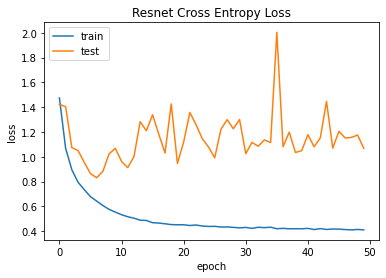

313/313 [==============================] - 1s 4ms/step - loss: 1.0679 - accuracy: 0.8031
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet 
i=  0
Epoch 1/5
391/391 [==============================] - 19s 49ms/step - loss: 0.3119 - val_loss: 1.2193
Epoch 2/5
391/391 [==============================] - 18s 46ms/step - loss: 0.2752 - val_loss: 1.1815
Epoch 3/5
391/391 [==============================] - 17s 45ms/step - loss: 0.2677 - val_loss: 1.1706
Epoch 4/5
391/391 [==============================] - 18s 45ms/step - loss: 0.2687 - val_loss: 1.2139
Epoch 5/5
391/391 [==============================] - 18s 45ms/step - loss: 0.2560 - val_loss: 1.3549
Epoch 1/5
391/391 [==============================] - 19s 50ms/step - loss: 0.3132 - val_loss: 1.1534
Epoch 2/5
391/391 [==============================] - 18s 45ms/step - loss: 0.2711 - val_loss: 1.2257
Epoch 3/5


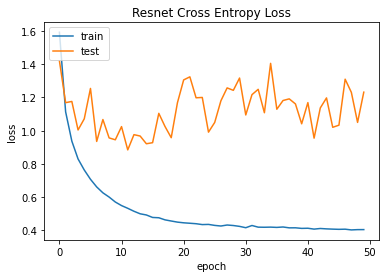

313/313 [==============================] - 1s 4ms/step - loss: 1.2321 - accuracy: 0.7774
INFO:tensorflow:Assets written to: /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet/assets
Saved trained model at /home/ANDURAND/serviceubu04/Pierre_Hakon/saved_models/Resnet 
i=  1
Epoch 1/5
391/391 [==============================] - 19s 49ms/step - loss: 0.3070 - val_loss: 1.1638
Epoch 2/5
391/391 [==============================] - 18s 47ms/step - loss: 0.2713 - val_loss: 1.2424
Epoch 3/5
391/391 [==============================] - 17s 45ms/step - loss: 0.2669 - val_loss: 1.2662
Epoch 4/5
391/391 [==============================] - 18s 45ms/step - loss: 0.2650 - val_loss: 1.1481
Epoch 5/5
391/391 [==============================] - 18s 45ms/step - loss: 0.2555 - val_loss: 1.4291
Epoch 1/5
391/391 [==============================] - 19s 49ms/step - loss: 0.3062 - val_loss: 1.1033
Epoch 2/5
391/391 [==============================] - 18s 46ms/step - loss: 0.2730 - val_loss: 1.3598
Epoch 3/5


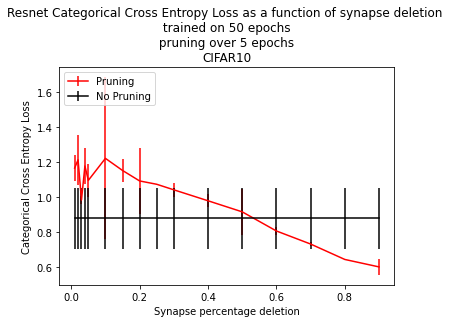

In [ ]:
synapse_deletion10, error_mean10, error_bar10, err_nopruning_mean10, err_nopruning_bar10 = run_train_and_prune('Resnet',
                                        'supervised', x_train_cifar, y_train_cifar,
                        x_test_cifar, y_test_cifar, iterations=2, epochs=50, epochs_prun=5, dataset='CIFAR10')

In [ ]:
fautoencoder=Fautoencoder()
tf.keras.utils.plot_model(fautoencoder, to_file='Fautoencoder.png', show_shapes=True)
fautoencoder.summary()
fautoencoder.count_params()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2000)              1570000   
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1000500   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_4 (Dense)              (None, 500)               5500      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_6 (Dense)              (None, 2000)             

5652794

In [ ]:
cautoencoder=Cautoencoder()
tf.keras.utils.plot_model(cautoencoder, show_shapes=True)
cautoencoder.summary()
cautoencoder.count_params()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 4, 4, 8)          

4385

In [ ]:
cnn1=CNN(input_shape=x_train_cifar.shape[1:])
#tf.keras.utils.plot_model(cnn1, show_shapes=True)
cnn1.summary()
cnn1.count_params()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 15, 15, 64)       

1250858

In [ ]:
resnet3,_=choose_resnet_model(input_shape=x_train_cifar.shape[1:], n=3, version=1)
#tf.keras.utils.plot_model(resnet3, show_shapes=True)
resnet3.summary()
resnet3.count_params()

Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 32, 32, 16)   64          conv2d_64[0][0]                  
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 32, 32, 16)   0           batch_normalization_19[0][0]     
______________________________________________________________________

274442